<a href="https://colab.research.google.com/github/erica-mccormick/storage_dynamics/blob/main/MASTER_P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part 2: Code for *Storage Dynamics* (In Prep, 2022)**

All analyses relating to statewide analyses are provided here. Sections 2.0 through 2.6 generate all of the products associated with the paper. Sections 2.7+ calculate relevant statistics and figures based on these products.

In [1]:
!pip install -q rasterio

     |████████████████████████████████| 19.3 MB 9.8 MB/s 


In [2]:
import rasterio as rio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from google.colab import files
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import glob
from scipy import stats
from os import path
import time
import datetime
import scipy


In [3]:
import ee
ee.Authenticate()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=BSUitd7LyOm5yHtla5Uk8inGcQrUhPALEzPrXfzfPyc&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWjCs4AJEJi-wJrrxuuG6zl9-8y6o3qsyOFk4XJBYac6xo_pZDon4GA

Successfully saved authorization token.


In [4]:
ee.Initialize()

*** Earth Engine *** Python client initialized


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**2.0** Export settings, utilized assets, & produced assets

Within the main directory, the subfolders "spearman", "carryover", "historical_percentile", "future_percentile", and "boxplots" are used and referred to within this code. For many analyses, it is necessary to wait for GEE to export to drive and then manually move tifs into the desired location.

In [13]:
export_tiffs = False

#directory = '/content/drive/MyDrive/Rock moisture/RM2b_MultiyearStorage/tiffs/drafts_round5/'
directory = '/content/drive/MyDrive/ROOTS N ROCK/Rock moisture/RM2b_MultiyearStorage/tiffs/drafts_round5/'

Useful dictionaries, including the thresholds for storage capacity and precipitation limitation for the 3 methods, as well as a list of site lat/lons.

In [15]:
# Utilized assets
ca = ee.Feature(ee.FeatureCollection('users/ericaelmstead/CA_State_TIGER2016_4326').first())


modis_landcover = ee.ImageCollection("MODIS/006/MCD12Q1").sort('system:time_start', False).first().select(['LC_Type1'],['Landcover']).reproject(crs='EPSG:4326',scale=500)
ca_carbon = ee.Image('users/ericamccormick/20_RockMoisture/Other/aboveground_biomass_carbon_2010_scaled_CA') #Mg carbon /hectar

pml = ee.ImageCollection("projects/pml_evapotranspiration/PML/OUTPUT/PML_V2_8day_v016") #extended to 2021
pml_multiplier = 8.0 # 8 day res
pml_scale = 0.01 # scaling factor

prism_monthly = ee.ImageCollection("OREGONSTATE/PRISM/AN81m") # monthly
prism = ee.ImageCollection("OREGONSTATE/PRISM/AN81d") # daily

snow_cover = ee.ImageCollection("MODIS/006/MOD10A1").select('NDSI_Snow_Cover')

# Assets produced using the code in sections 2.0 to 2.7
mask = ee.Image('users/ericaelmstead/mask')
mask_landcover = ee.Image('users/ericaelmstead/mask_landcover')
selected_landcover = ee.Image('users/ericaelmstead/selected_landcover')
et_gt_p = ee.Image('users/ericaelmstead/et_gt_p')
sr_2017 = ee.Image('users/ericaelmstead/sr_2017')
sr_2020 = ee.Image('users/ericaelmstead/sr_2020')
sr_diff = ee.Image('users/ericaelmstead/sr_diff')
max_dmax = ee.Image('users/ericaelmstead/max_dmax')
carryover_mag = ee.Image('users/ericaelmstead/carryover_mag')
carryover_perc = ee.Image('users/ericaelmstead/carryover_perc') # result of Method 2
deltaP_mag = ee.Image('users/ericaelmstead/deltaP_mag')
deltaP_perc = ee.Image('users/ericaelmstead/deltaP_perc')
spearman_corr = ee.Image('users/ericaelmstead/spearman_corr')
spearman_pval = ee.Image('users/ericaelmstead/spearman_pval')
percentile = ee.Image('users/ericaelmstead/percentile_historical')
future_agreement_transition = ee.Image('users/ericaelmstead/future_agreement_transition')

In [16]:
# Cutoff thresholds for precipitation (gt cutoff) vs storage capacity limitation (lte cutoff)
thresholds = {"spearman":{"asset_name":spearman_corr, "cutoff":0.34, "band_name":'b1'},
              "carryover":{"asset_name": carryover_perc, "cutoff":0.09, "band_name":'D'},
              "percentile":{"asset_name":percentile, "cutoff":0, "band_name":'b1'}}

# Dictionary of site coordinates
site_names = ["Packsaddle Pass", "Parker Pass", "Providence","Soaproot","Rivendell","Sagehorn","Rancho Venada","Random Precip Limited"]
site_lats = [35.928, 35.928, 37.0651, 37.067338, 39.7273, 39.574518, 39.1524, 36.5272]
site_lons = [-118.597, -118.597, -119.1795, -119.1952, -123.6433, -123.477, -122.34869,-118.8003]
site_coords = {}
for i in range(len(site_names)):
    site_coords.update({site_names[i]:{'Lat':site_lats[i], 'Lon':site_lons[i]}})

In [17]:
# FOR QUICK EXPORTING OF RANDOM STUFF
'''
task_config = {
        'region': ca.geometry(),
        'fileFormat': 'GeoTIFF',
        'fileNamePrefix': 'future_agreement_transition',
        'folder': 'future',
        'image': future_agreement_transition.updateMask(mask).clip(ca.geometry()).toDouble(),
        'description': 'future_agreement_transition',
        'scale': 500,
        'maxPixels': 10000000000000
    }

task=ee.batch.Export.image.toDrive(**task_config)
task.start()

# To update list of assets
beginning_string = 'users/ericaelmstead/22_StorageDynamics/'
file_name = ['mask', 'mask_landcover', 'et_gt_p', 'sr_2017', 'sr_2020',
       'sr_diff', 'max_dmax', 'carryover_mag', 'carryover_perc',
       'deltaP_mag', 'deltaP_perc']
tests = [beginning_string + i for i in file_name]

'''

"\ntask_config = {\n        'region': ca.geometry(),\n        'fileFormat': 'GeoTIFF',\n        'fileNamePrefix': 'future_agreement_transition',\n        'folder': 'future',\n        'image': future_agreement_transition.updateMask(mask).clip(ca.geometry()).toDouble(),\n        'description': 'future_agreement_transition',\n        'scale': 500,\n        'maxPixels': 10000000000000\n    }\n\ntask=ee.batch.Export.image.toDrive(**task_config)\ntask.start()\n\n# To update list of assets\nbeginning_string = 'users/ericaelmstead/22_StorageDynamics/'\nfile_name = ['mask', 'mask_landcover', 'et_gt_p', 'sr_2017', 'sr_2020',\n       'sr_diff', 'max_dmax', 'carryover_mag', 'carryover_perc',\n       'deltaP_mag', 'deltaP_perc']\ntests = [beginning_string + i for i in file_name]\n\n"

In [18]:
# Check values for a site
site = 'Rivendell'
ft = ee.Feature(ee.Geometry.Point((site_coords[site]['Lon'],site_coords[site]['Lat'])))
result = future_agreement_transition.reduceRegion(ee.Reducer.first(), ft.geometry(), 500)
result.getInfo()

{'b1': 0}

# **2.1** Landcover and ET<P mask

Select forested and shrubland MODIS landcover types.

In [19]:
selected_landcover  = modis_landcover.remap([1, 2, 3, 4, 5, 8, 9], [1, 2, 3, 4, 5, 8, 9]) #Image.remap(from, to, defaultValue, bandName)	
landcover_mask = selected_landcover.gt(0)

Mask out places where ET>P and export locations that will be excluded because of ET>P (SI Figure ##).

In [20]:
# Total ET

es = pml.select('Es').filterDate('2002-10-01', '2021-10-01').sum()
ec = pml.select('Ec').filterDate('2002-10-01', '2021-10-01').sum()
ET_total = es.add(ec).multiply(pml_multiplier).multiply(pml_scale)

# Total P
P_total = prism_monthly.select('ppt').filterDate('2002-10-01', '2021-10-01').sum()

# Subtract
ETgtP = P_total.subtract(ET_total).lt(0)
ETltP = P_total.subtract(ET_total).gt(-1)

# ETgtP area to be removed (ie where forest landcover exists)
excluded = ETgtP.updateMask(landcover_mask)

# Final mask to be used for remainder of analyses
mask = landcover_mask.updateMask(ETltP)

# **2.2** Method 1

First, export 2 tifs of $ET_{summer}$ and $P_{wy}$ where each band is the water year sum.

In [21]:
# Get wet season water year precip and summer ET for each year
p_list = []
et_list = []

for wy in range(2002,2020): #wateryears 2003-2021
  # get the precip image
  start_date = str(wy) + '-10-01'
  end_date = str(wy+1) + '-10-01'
  prism_wy_ppt = ee.Image(prism_monthly.select('ppt').filterDate(start_date, end_date).sum())
  p_list.append(prism_wy_ppt)


  #get the summer ET image
  start_date = str(wy+1) + '-05-01' #May 1st
  end_date = str(wy+1) + '-10-01' #September 31st
  pml_summer_Ec = ee.Image(pml.select('Ec').filterDate(start_date, end_date).sum())
  pml_summer_Es = ee.Image(pml.select('Es').filterDate(start_date, end_date).sum())
  pml_summer_ET = pml_summer_Ec.add(pml_summer_Es).multiply(pml_multiplier).multiply(pml_scale)
  et_list.append(pml_summer_ET)

# Convert list to ImageCollection
et_collection = ee.ImageCollection(et_list)
p_collection = ee.ImageCollection(p_list)

# Convert ImageCollection to Image with bands for each year and mask to study area
spearman_et_image = et_collection.toBands().updateMask(mask).reproject(crs='EPSG:4326', scale=500).clip(ca.geometry())
spearman_p_image = p_collection.toBands().updateMask(mask).reproject(crs='EPSG:4326', scale=500).clip(ca.geometry())

if export_tiffs == True:
  task_config = {
          'region': ca.geometry(),
          'fileFormat': 'GeoTIFF',
          'fileNamePrefix': 'spearman_et_summer',
          'folder': 'interim',
          'image': spearman_et_image,
          'description': 'spearman_et_summer',
          'scale': 500,
          'maxPixels': 10000000000000
      }

  task=ee.batch.Export.image.toDrive(**task_config)
  task.start()

  task_config = {
          'region': ca.geometry(),
          'fileFormat': 'GeoTIFF',
          'fileNamePrefix': 'spearman_p_wy',
          'folder': 'interim',
          'image': spearman_p_image,
          'description': 'spearman_p_wy',
          'scale': 500,
          'maxPixels': 10000000000000
      }

  task=ee.batch.Export.image.toDrive(**task_config)
  task.start()

Next, import tifs as arrays and calculate the Spearman correlation coefficient and p-value. Importing arrays is necessary as of this writing because the GEE Spearman reducer fails to provide a p-value band.

In [22]:
if export_tiffs == True:
  et_path = directory + 'interim/spearman_et_summer.tif'
  p_path =  directory + 'interim/spearman_p_wy.tif'

  et_tif = rio.open(et_path)
  transform = et_tif.transform # save this for transforming flattened array back to map dimensions
  et_array = et_tif.read()

  p_tif = rio.open(p_path)
  p_array = p_tif.read() 
  shape = p_array.shape

In [23]:
if export_tiffs == True:
  corr = np.empty([shape[1], shape[2]])
  pval = np.empty([shape[1], shape[2]])
  for x in range(shape[1]):
    for y in range(shape[2]):
      # Spearman rank correlation coefficient
      corr[x,y], pval[x,y] = scipy.stats.spearmanr(p_array[:, x, y], et_array[:,x,y], nan_policy='propagate')


In [24]:
def export_tif(vals, filename):
  vals_reshaped = vals.reshape(shape[1],shape[2])

  filepath = directory + 'spearman/'+ str(filename) + '.tif'
  new_dataset = rio.open(filepath, 'w', driver='GTiff',
                              height = vals_reshaped.shape[0], width = vals_reshaped.shape[1],
                              count=1, dtype=str(vals_reshaped.dtype),
                              crs='EPSG:4326',
                            transform=transform)

  new_dataset.write(vals_reshaped, 1)
  new_dataset.close()

if export_tiffs == True:
  export_tif(vals = corr, filename = 'spearman_corr')
  export_tif(vals = pval, filename = 'spearman_pval')

# **2.3** Method 2

This code uses the deficit timeseries originally published in McCormick et al., 2021 (https://doi.org/10.1038/s41586-021-03761-3) with the full code and documentation available [here](https://ericamccormick.com/widespread-bedrock-water-use/). Here is a function to get an ImageCollection of the deficit to be used throughout this section.

In [25]:
def get_deficit_collection(yearstart, yearend):
  prism = ee.ImageCollection("OREGONSTATE/PRISM/AN81d")
  pml = ee.ImageCollection("projects/pml_evapotranspiration/PML/OUTPUT/PML_V2_8day_v016") #pml that continues to 2020
  snow_cover = ee.ImageCollection("MODIS/006/MOD10A1").select('NDSI_Snow_Cover')

  #Flux is stored as mm/day with 0.01 scale, and duration between samples is 8 days
  multiplier = 8.0 
  scale = 0.01

  #### USING SNOW CORRECTION METHOD ####
  # threshold of non-snow-fraction above which we assume that there is 
  # negligible snow in the image
  threshold = 0.9
  # mapping function for creating ET time series but set to zero (Fout = 0) during
  # periods when snow is present
  def sumpml_snow(image):
    #First, get percent snow coverage for nearest datetime
    current_datetime = datetime.datetime.now().strftime('%Y-%m-%d')
    nearest_snow_image = snow_cover.filterDate(image.get('system:time_start'), 
                                              current_datetime).first() 
    #reproject
    nearest_snow_image= nearest_snow_image.reproject(crs='EPSG:4326',scale=500)
    non_snow_frac = ee.Image(1).subtract(nearest_snow_image.divide(100))
    #assign non-snow fraction to 1 if nodata
    non_snow_frac=non_snow_frac.unmask(1)

    # zero multiplier if there is less than threshold non snow frac
    # i.e. if there is significant snow in the image
    snow_multiplier = non_snow_frac.gt(threshold)

    # get total surface evap and transpiration, zero out if significant snow
    temp = image.select('Es').add(image.select('Ec')).multiply(snow_multiplier)

    #get the first band of this new temporary image, rename it to 'ET', 
    #reproject it, and then multiply by 8
    temp = temp.select([0], ['ET']).reproject(
        crs='EPSG:4326',scale=500
        ).multiply(multiplier).multiply(scale)
    #temp should now be total ET in mm over the time window between images
    #assign the datetime stamp and the index from the original image
    temp = temp.set('system:time_start', image.get('system:time_start'))
    temp = temp.set('system:index', image.get('system:index'))
    return temp

  #now, actually map the pml image collection w/ this function,
  # in order to make a new combined ET image collection
  et_snow_corr = ee.ImageCollection(pml.map(sumpml_snow).select('ET'))

  # function use to calculate A_{t_n} values and running storage deficit
  def get_AD(et, yearstart, yearend):
    start_wy = str(yearstart) + "-10-01"
    end_wy = str(yearend) + "-09-30"
    et_current = et.filterDate(start_wy, end_wy)
    prism = ee.ImageCollection('OREGONSTATE/PRISM/AN81d').select('ppt')

    # Create starting image for iterator used to calculate A_{t_n}
    starter = ee.Image(et_current.first())
    # set the time of the starter image to 8 days before first ET image
    time0 = starter.get('system:time_start').getInfo() - 691000000
    first = ee.List([ee.Image(0).set('system:time_start', time0).select([0], ['A']).toDouble()])

    # for each item in the ET (F_out) time series, 
    # get cumulative precip (F_in) since previous F_out
    # Take the difference between F_out and F_in; this is A
    def getA(image, thelist):
      previous = ee.Image(ee.List(thelist).get(-1))
      startdate = previous.get('system:time_start')
      enddate = image.get('system:time_start')
      windowed_prism = prism.filterDate(startdate,enddate)
      prism_total = windowed_prism.reduce(ee.Reducer.sum())
      Atemp = image.subtract(prism_total)
      Atemp = Atemp.select([0], ['A']).toDouble()
      Atemp = Atemp.set({'system:time_start':image.get('system:time_start')})
      return ee.List(thelist).add(Atemp)
    # iterate using getA() 
    A = ee.ImageCollection(ee.List(et_current.iterate(getA, first)))

    # add band to keep track of running storage deficit calculation
    def add_deficit_band(image):
      return image.addBands(ee.Image.constant(0).rename('D')).toDouble()
    AD_initial = A.map(add_deficit_band)
    starter = ee.Image(AD_initial.first()).multiply(0)

    ts = AD_initial.first().get('system:time_start')
    starter = starter.set('system:time_start', ts)

    first = ee.List([starter])
    # iterator we will use to calculate running storage deficit
    def accumulate(image, thelist):
      # get image with previous D values
      previous = ee.Image(ee.List(thelist).get(-1))
      previousD = previous.select('D')

      # get current value of A = F_out - F_in
      currentA = image.select('A')

      # D is just previous D plus current A
      newD = previousD.add(currentA)

      # if storage deficit is < 0, set it to zero (can only be positive)
      newD = newD.multiply(newD.gt(0))

      # add to list over which we are iterating
      tempAD = currentA.addBands(newD)
      return ee.List(thelist).add(tempAD)

    # Get storage deficit time series, take maximum observed storage deficit
    AD = ee.ImageCollection(ee.List(AD_initial.iterate(accumulate, first)))
    return AD

  # get max storage deficit using non-snow-corrected and snow-corrected F_out

  def add_time_band(image):
    t = ee.Number(image.get('system:time_start')).toLong() #changed from .toLong()
    timeimage = ee.Image(t).select([0],['t'])
    image = image.addBands(timeimage)
    image = image.toLong()
    return image

  deficit = get_AD(et_snow_corr, yearstart, yearend)
  deficit = deficit.map(add_time_band, opt_dropNulls=True)

  return deficit


## $S_r$ (SI Fig ##)

Get an ImageCollection with the deficit from water years 2003 to 2020. Retain the 2003-2014 deficit for comparison with the 2003-2020 deficit for SI Figures ## and ##. $S_r$ is the maximum value of the deficit.

In [26]:
deficit_2014 = get_deficit_collection(2003, 2014)
deficit_add = get_deficit_collection(2014, 2020)
deficit_2020 = deficit_2014.merge(deficit_add)

In [27]:
Sr_2014 = deficit_2014.qualityMosaic('D').select(['D','t']).updateMask(mask)
Sr_2020 = deficit_2020.qualityMosaic('D').select(['D','t']).updateMask(mask)
Sr_diff = Sr_2020.subtract(Sr_2014)

SI Table ##: The difference between $S_r$ to 2014 and $S_r$ to 2020.

In [28]:
sites = ['Random Precip Limited', 'Rivendell', 'Packsaddle Pass', 'Soaproot','Sagehorn','Rancho Venada']
sr_2014s = np.zeros(6)
sr_2020s = np.zeros(6)

for i in range(6):
  ft = ee.Feature(ee.Geometry.Point((site_coords[sites[i]]['Lon'],site_coords[sites[i]]['Lat'])))

  result_2014 = Sr_2014.reduceRegion(ee.Reducer.first(), ft.geometry(), 500)
  result_2020 = Sr_2020.reduceRegion(ee.Reducer.first(), ft.geometry(), 500)
  sr_2014s[i] = result_2014.get('D').getInfo()
  sr_2020s[i] = result_2020.get('D').getInfo()

df = pd.DataFrame({'sites':sites, 'Sr2014':sr_2014s,'Sr2020':sr_2020s})
df

,sites,Sr2014,Sr2020
0,Random Precip Limited,NaN,NaN
1,Rivendell,384.0,405.0
2,Packsaddle Pass,894.0,894.0
3,Soaproot,578.0,578.0
4,Sagehorn,257.0,328.0
5,Rancho Venada,NaN,NaN


## $D_{max}$

In [29]:
dmax_values = []
dmax_timeseries = []

for year in np.arange(2003, 2020):
  deficit_annual = get_deficit_collection(year, year+1)
  dmax_timeseries.append(deficit_annual)
  dmax_values.append(deficit_annual.qualityMosaic('D').select(['D','t']))

dmax_values_col = ee.ImageCollection(dmax_values)

# Calculate Max(Dmax)
max_dmax = dmax_values_col.qualityMosaic('D').select(['D','t']).updateMask(mask)

In [30]:
dmax_values_14 = []
dmax_timeseries_14 = []

for year in np.arange(2003, 2014):
  deficit_annual_14 = get_deficit_collection(year, year+1)
  dmax_timeseries_14.append(deficit_annual_14)
  dmax_values_14.append(deficit_annual_14.qualityMosaic('D').select(['D','t']))

dmax_values_col_14 = ee.ImageCollection(dmax_values_14)

# Calculate Max(Dmax)
max_dmax_14 = dmax_values_col_14.qualityMosaic('D').select(['D','t']).updateMask(mask)

## Carryover

The deficit timeseries is used to calculate the fraction of root-zone water storage capacity which can be attributed to deficit accrued from multi-year storage:

Carryover = fraction of $S_r$ generated from multiyear storage = $\frac{S_r - max(D_{max})}{S_r}$

Where $S_r$ is the root-zone water storage capacity calculated in the method of McCormick et al., 2021 from the years 2003 to 2021 and $D_{max}$ is the maximum water year root-zone water storage deficit. See McCormick et al., 2021 and Dralle et al., 2021 for details and data products.

In [31]:
carryover_perc = (Sr_2020.subtract(max_dmax)).divide(Sr_2020).updateMask(mask).select('D')
carryover_mag = Sr_2020.subtract(max_dmax).updateMask(mask).select('D')

In [32]:
carryover_14_perc = (Sr_2014.subtract(max_dmax_14)).divide(Sr_2014).updateMask(mask).select('D')
carryover_14_mag = Sr_2014.subtract(max_dmax_14).updateMask(mask).select('D')

diff_carryover_14_perc = carryover_perc.subtract(carryover_14_perc)
diff_carryover_14_mag = carryover_mag.subtract(carryover_14_mag)

#**2.4** Method 3

First, export a tif with one band for each cumulative water year's precipitation from 1980 to 2020 and one band with $S_r$ (to 2020).

In [ ]:
ims = []
for wy in range(1980,2020):
  # get the precip image
  start_date = str(wy) + '-10-01'
  end_date = str(wy+1) + '-10-01'
  prism_wy_ppt = ee.Image(prism_monthly.select('ppt').filterDate(start_date, end_date).sum())
  ims.append(prism_wy_ppt)

percentile_p_collection = ee.ImageCollection(ims)

percentile_p_image = percentile_p_collection.toBands().reproject(crs='EPSG:4326', scale=500).clip(ca.geometry())  #image collection of all water year Ps
percentile_p_sr_stack = percentile_p_image.addBands(Sr_2020.select('D')).updateMask(mask).clip(ca.geometry()).toDouble()

if export_tiffs == True:
  task_config = {
          'region': ca.geometry(),
          'fileFormat': 'GeoTIFF',
          'fileNamePrefix': 'percentile_p_sr_stack',
          'folder': 'interim',
          'image': percentile_p_sr_stack,
          'description': 'percentile_p_sr_stack',
          'scale': 500,
          'maxPixels': 10000000000000
      }

  task=ee.batch.Export.image.toDrive(**task_config)
  task.start()

Next, import 41 band raster as array using rasterio and calculate the percentile of $S_r$ relative to the distribution of $P_{wy}$.

In [ ]:
percentile_path =  directory + 'interim/percentile_p_sr_stack.tif'
if export_tiffs == True:
  tif = rio.open(percentile_path)
  transform = tif.transform #save this for transforming flattened array back to map dimensions
  array_precip = tif.read((tuple(np.arange(1,40)))) # first 40 bands contain water year precipitation
  array_sr = tif.read(41) # last band contains Sr
  shape = array_sr.shape

  blank_array = np.empty([shape[0], shape[1]])
  for x in range(shape[0]):
    for y in range(shape[1]):
      blank_array[x,y] = scipy.stats.percentileofscore(array_precip[:, x, y], array_sr[x,y], kind = 'weak')

  new_dataset = rio.open(directory + 'percentile/percentile_historical_v2.tif', 'w', driver='GTiff',
                              height = blank_array.shape[0], width = blank_array.shape[1],
                              count=1, dtype=str(blank_array.dtype),
                              crs='EPSG:4326',
                            transform = transform)

  new_dataset.write(blank_array, 1)
  new_dataset.close()

#**2.6** Future precipitation

## Necessary change in future P to induce transition

The percent change in the 25th percentile of future precipition necessary to transition from storage capacity to precipitation limitation = $S_r$ - P25($P_{1981-2021}$) / P25($P_{1981-2021}$) 

In [ ]:
# Clip to storage capacity limited places according to the carryover method (could choose any one)
storagecap = carryover_perc.lt(0.10) #10% cutoff

# Get MinP
ims = []
for wy in range(1980,2020):
  # get the precip image
  start_date = str(wy) + '-10-01'
  end_date = str(wy+1) + '-10-01'
  prism_wy_ppt = ee.Image(prism_monthly.select('ppt').filterDate(start_date, end_date).sum())
  ims.append(prism_wy_ppt)
p = ee.ImageCollection(ims)

p25 = p.reduce(**{'reducer': ee.Reducer.percentile([25])})

# Also export MAP (wy) for use in boxplots
map_wy = p.reduce(**{'reducer': ee.Reducer.mean()})

# Magnitude of deltaP necessary
deltaP_mag = Sr_2020.select('D').subtract(p25).updateMask(storagecap)

# Percent change necessary
deltaP_perc = deltaP_mag.divide(p25).updateMask(storagecap)


NameError: ignored

## Projected P percentile agreement

Calculate the number of models that agree on transition from storage capacity to precipitation limitation and the number of models that agree on worsening precipitation limitation. This analyses uses manually imported GEE assets of the future percentile tifs, made using future_percentile.py file, as well as a GEE asset of the results of Method 3 for historical precipitation. 

In [ ]:
models = ['CCSM4_rcp45', 'CESM1-BGC_rcp45','CMCC-CMS_rcp45', 'CanESM2_rcp45', 'GFDL-CM3_rcp45','HadGEM2-CC_rcp45', 'MIROC5_rcp45','ACCESS1-0_rcp45','HadGEM2-ES_rcp45','CNRM-CM5_rcp45']
name = ['percentile_' + model for model in models] #split('_')[0]
name

['percentile_CCSM4_rcp45',
 'percentile_CESM1-BGC_rcp45',
 'percentile_CMCC-CMS_rcp45',
 'percentile_CanESM2_rcp45',
 'percentile_GFDL-CM3_rcp45',
 'percentile_HadGEM2-CC_rcp45',
 'percentile_MIROC5_rcp45',
 'percentile_ACCESS1-0_rcp45',
 'percentile_HadGEM2-ES_rcp45',
 'percentile_CNRM-CM5_rcp45']

In [ ]:
# Use GEE asset of historical percentile for comparison
percentile = ee.Image('users/ericaelmstead/percentile_historical')

# Names of the models, which are the GEE asset names
models = ['CCSM4_rcp45', 'CESM1-BGC_rcp45','CMCC-CMS_rcp45', 'CanESM2_rcp45', 'GFDL-CM3_rcp45','HadGEM2-CC_rcp45', 'MIROC5_rcp45','ACCESS1-0_rcp45','HadGEM2-ES_rcp45','CNRM-CM5_rcp45']
name = ['percentile_' + model for model in models] #split('_')[0]

# List of images to save
diff = []
agreement = []

# Import future percentiles
for i in name:
  perc = ee.Image('users/ericaelmstead/22_StorageDynamics/cali_ten_model_precip/' + i)

  # Get images of the difference in just the previously storage capacity limited areas
  temp = perc.subtract(percentile).updateMask(percentile.lte(thresholds['percentile']['cutoff']))
  diff.append(temp)

  agreement_temp = temp.gt(0).updateMask(percentile.lte(thresholds['percentile']['cutoff']))
  agreement.append(agreement_temp)

# Sum up the agreements
future_agreement_transition = ee.ImageCollection(agreement).reduce(**{'reducer': ee.Reducer.sum()})



In [40]:
# Agreement on worsening of precipitation limitation
# Names of the models, which are the GEE asset names
models = ['CCSM4_rcp45', 'CESM1-BGC_rcp45','CMCC-CMS_rcp45', 'CanESM2_rcp45', 'GFDL-CM3_rcp45','HadGEM2-CC_rcp45', 'MIROC5_rcp45','ACCESS1-0_rcp45','HadGEM2-ES_rcp45','CNRM-CM5_rcp45']
name = ['percentile_' + model for model in models] #split('_')[0]

# List of images to save
agreement_worsening = []

# Import future percentiles
for i in name:
  perc = ee.Image('users/ericaelmstead/22_StorageDynamics/cali_ten_model_precip/' + i)

  # Get images of the difference in just the previously storage capacity limited areas
  temp = perc.subtract(percentile).updateMask(percentile.gt(thresholds['percentile']['cutoff']))

  agreement_worsening_temp = temp.gt(0).updateMask(percentile.gt(thresholds['percentile']['cutoff']))
  agreement_worsening.append(agreement_worsening_temp)

# Sum up the agreements
future_agreement_worsening = ee.ImageCollection(agreement_worsening).reduce(**{'reducer': ee.Reducer.sum()})



#**2.7** Export

**Important**: All of the "interim" folder exports which occur before this section must be complete before running this section. The necessary files include:
*   spearman_et_summer
*   spearman_p_wy
*   percentile_p_sr_stack

**File metadata**: Use metadata to set up a dictionary to call images for export.

In [ ]:
#'https://docs.google.com/spreadsheets/d/1hCRpWxp2giABl7MwW1y1HDhR2MNqbjmh4r8BT8ENDCY/edit#gid=0'

docID = '1hCRpWxp2giABl7MwW1y1HDhR2MNqbjmh4r8BT8ENDCY'
gID = '0'
metadata = pd.read_csv('https://docs.google.com/spreadsheets/d/' + docID + '/export?gid=' + gID + '&format=csv')
metadata.head()

,file_name,var_name,folder,units,description
0,mask,mask,masks,1 = included; 0 = excluded,"The mask of the study area, ie where forested/..."
1,mask_landcover,landcover_mask,masks,1 = included; 0 = excluded,The forested/shrubland landcover type area use...
2,et_gt_p,excluded,masks,1 = excluded from study,Forested area excluded from the study because ...
3,sr_2017,Sr_2017,carryover,mm,"Sr, ie root-zone water storage capacity, calcu..."
4,sr_2020,Sr_2020,carryover,mm,"Sr, ie root-zone water storage capacity, calcu..."


In [ ]:
# Get a dictionary of var_names to the actual variables
metadata_export = metadata[metadata['var_name'].notnull()]
metadata_export =  metadata_export[metadata_export['folder'] != 'interim']
metadata_export.var_name.values

array(['mask', 'landcover_mask', 'excluded', 'Sr_2017', 'Sr_2020',
       'Sr_diff', 'max_dmax', 'carryover_mag', 'carryover_perc',
       'deltaP_mag', 'deltaP_perc'], dtype=object)

In [ ]:
metadata_export.file_name.values

array(['mask', 'mask_landcover', 'et_gt_p', 'sr_2017', 'sr_2020',
       'sr_diff', 'max_dmax', 'carryover_mag', 'carryover_perc',
       'deltaP_mag', 'deltaP_perc'], dtype=object)

In [ ]:
# Copy the above var names and take out the () to get the vars list
vars = [mask, landcover_mask, excluded, Sr_2017, Sr_2020,
       Sr_diff, max_dmax, carryover_mag, carryover_perc,
       deltaP_mag, deltaP_perc]

export_dic = {}
for i in range(len(metadata_export['var_name'])):
  export_dic.update({metadata_export['var_name'].values[i]:{'var':vars[i], 'file_name': metadata_export['file_name'].values[i], 'folder': metadata_export['folder'].values[i]}})


## **Export all tifs to drive**

In [ ]:
for key in export_dic:
  task_config = {
          'region': ca.geometry(),
          'fileFormat': 'GeoTIFF',
          'fileNamePrefix': export_dic[key]['file_name'],
          'folder': export_dic[key]['folder'],
          'image': export_dic[key]['var'].updateMask(mask).toDouble(),
          'description': export_dic[key]['file_name'],
          'scale': 500,
          'maxPixels': 10000000000000
      }

  task=ee.batch.Export.image.toDrive(**task_config)
  task.start()

## **Export all tifs to GEE assets**

In [ ]:
for key in export_dic:
  task_config = {
          'region': ca.geometry(),
          'image': export_dic[key]['var'].updateMask(mask),
          'description': export_dic[key]['file_name'],
          'assetId' : 'users/ericaelmstead/' + export_dic[key]['file_name'],
          'scale': 500,
          'maxPixels': 10000000000000
      }

  task=ee.batch.Export.image.toAsset(**task_config)
  task.start()

#**2.8** Boxplots

## Export stacked tifs

First, export stacked rasters with the variables of interest (ie the limitation classification, elevation, mean annual precipitation (MAP), landcover class, and the area of each pixel)

In [ ]:
def select_method(method):
  if method == 'spearman':
    precip = thresholds[method]["asset_name"].gt(thresholds[method]["cutoff"]).multiply(2)
    storagecap = thresholds[method]["asset_name"].lte(thresholds[method]["cutoff"])
    binary = precip.add(storagecap).updateMask(mask)
    band_name = thresholds[method]["band_name"]

  elif method == 'carryover':
    precip = thresholds[method]["asset_name"].gt(thresholds[method]["cutoff"]).multiply(2)
    storagecap = thresholds[method]["asset_name"].lte(thresholds[method]["cutoff"])
    binary = precip.add(storagecap).updateMask(mask)
    band_name = thresholds[method]["band_name"]

  elif method == 'percentile':
    precip = thresholds[method]["asset_name"].gt(thresholds[method]["cutoff"]).multiply(2)
    storagecap = thresholds[method]["asset_name"].lte(thresholds[method]["cutoff"])
    binary = precip.add(storagecap).updateMask(mask)
    band_name = thresholds[method]["band_name"]
  else:
    print('Method choices are: spearman, carryover, or percentile')

  return binary, band_name

In [ ]:
def export_with_vars(method, export_tiffs, return_all = False):

  scale = 500

  # SR-ORG:6974, 500m
  landcover = (ee.Image('users/ericaelmstead/selected_landcover')
    .select([0],['Landcover'])
    .reproject(crs='EPSG:4326',scale=scale))

  # EPSG:4326
  map = (ee.Image('users/ericaelmstead/MAP_wy')
    .clip(ca.geometry())
    .select(['b1'],['map'])
    .reduceResolution(reducer = ee.Reducer.mean(), bestEffort=True, maxPixels=150)
    .reproject(crs='EPSG:4326',scale=scale))

  elevation = (ee.Image("USGS/SRTMGL1_003")
    .clip(ca.geometry())
    .reduceResolution(reducer = ee.Reducer.mean(), bestEffort=True, maxPixels=150)
    .reproject(crs='EPSG:4326',scale=scale))

  mortality = (ee.Image('users/ericaelmstead/mortality_noneg_4326')
    .clip(ca.geometry())
    .select(['b1'],['Mortality'])
    .reduceResolution(reducer = ee.Reducer.mean(), bestEffort=True, maxPixels=150)
    .reproject(crs='EPSG:4326',scale=scale))
          
  
  biomass =  (ee.Image('users/ericamccormick/20_RockMoisture/Other/aboveground_biomass_carbon_2010_scaled_CA') #ca_carbon asset
      .clip(ca.geometry())
      .select(['b1'],['carbon'])
      .reduceResolution(reducer = ee.Reducer.mean(), bestEffort=True, maxPixels=150)
      .reproject(crs='EPSG:4326',scale=scale))

  # Categorization band and area in m^2
  binary, band_name = select_method(method)
  area = binary.pixelArea().reproject(crs='EPSG:4326',scale=scale).select([0],['area'])

  ## Combine into one image with 4 bands
  all = binary.select([0],['category']).addBands(landcover).addBands(map).addBands(elevation).addBands(mortality).addBands(biomass).addBands(area)

  if export_tiffs == True:
    to_save = all.toDouble().updateMask(landcover_mask).clip(ca.geometry()) #mask this with landcover only, not with ET<P
    task_config = {
            'region': ca.geometry(),
            'fileFormat': 'GeoTIFF',
            'fileNamePrefix': method + '_with_vars_biomass',
            'folder': 'boxplots',
            'image': to_save,
            'description': method + '_with_vars_biomass',
            'scale': 500,
            'maxPixels': 10000000000000
        }

    task=ee.batch.Export.image.toDrive(**task_config)
    task.start()

  if return_all == True:
    return all

In [ ]:
export_with_vars(method = 'spearman', export_tiffs = export_tiffs, return_all = False)
export_with_vars(method = 'carryover', export_tiffs = export_tiffs, return_all = False)
export_with_vars(method = 'percentile', export_tiffs = export_tiffs, return_all = False)

print('Bands for conversion to df below:')
test = export_with_vars(method = 'percentile', export_tiffs = False, return_all = True)
test.bandNames().getInfo()

Bands for conversion to df below:


['category', 'Landcover', 'map', 'elevation', 'Mortality', 'carbon', 'area']

## Method agreement

In [ ]:
# Fresh import of assets
spearman_corr = ee.Image('users/ericaelmstead/spearman_corr')
percentile = ee.Image('users/ericaelmstead/percentile_historical')
carryover_perc = ee.Image('users/ericaelmstead/carryover_perc') # result of Method 2

# Count the number of methods that agree on precipitation limitation
cat_agreement = (ee.Image(0)
  .add(spearman_corr.gt(thresholds['spearman']["cutoff"]))
  .add(carryover_perc.gt(thresholds['carryover']["cutoff"]))
  .add(percentile.gt(thresholds['percentile']["cutoff"]))
  ).select(['constant'],['agreement_plim'])


## Plot

Next, open these tifs as arrays and calculate the area of each limitation category for each method using the get_area_boxplot() function.

In [ ]:
### Visualization and binning params ###

# Set up colors for barplot
c = {"spearman":'#9F4476',#944A74',
              "carryover":'#D45B9D',
              "percentile":'#D8A4BF',#D0A7BE',
              "storagecap":'#DBD3E1', # D9D3E0 #4682b4
              "remainder":'#bcbcbc'}

# Binning parameters

#landcover_bins = [1, 2, 4, 5, 8, 9]
#names_selected = ['Evergreen\nNeedleleaf\nForests', 'Evergreen\nBroadleaf\nForests', 'Deciduous\nBroadleaf\nForests','Mixed\nForests', 'Woody\nSavannas','Savannas']
landcover_bins = [1,2]
names_selected = ['Forest', 'Savanna']

biomass_bins = [25, 50, 75, 100, 125, 150, 1000]
biomass_bin_names = ['0-25','25-50','50-75','75-100','100-125','125-150','>150']
biomass_bin_cats = [0, 1, 2, 3, 4, 5, 6] #check these are all the values that come up

elevation_bins = [0,  250, 500, 1000, 1500, 2000, 2500, 3500] #edited 4000 to 4100 to catch 2 pixels >4000
elevation_bin_names = ['0-250', '250-500','500-1000','1000-1500','1500-2000','2000-2500','>2500']
elevation_bin_cats = [1, 2, 3, 4, 5, 6, 7]

map_bins = [0, 500, 750, 1000, 1250, 1500, 1750]
map_bin_names = ['0-500','500-750','750-1000','1000-1250','1250-1500','1500-1750','>1750']
map_bin_cats = [1,2,3,4,5,6,7]

mortality_bins = [5, 10, 15, 20, 25, 30, 250]
mortality_bin_names = ['0-5','5-10','10-15','15-20','20-25','25-30','>30']
mortality_bin_cats = [0, 1, 2, 3, 4, 5, 6]
mortality_plot_bins = [1,2,3,4,5,6]

binning = {'Landcover': {'bins': landcover_bins, 'plot_bins':landcover_bins, 'cats':landcover_bins, 'names':names_selected, 'col': 'Landcover', 'xlabel':'Landcover'}, 
           'Elevation':{'bins':elevation_bins, 'plot_bins': elevation_bins, 'cats':elevation_bin_cats, 'names':elevation_bin_names, 'col': 'binned_elev', 'xlabel':'Elevation (m)'},
           'MAP':{'bins':map_bins, 'plot_bins':map_bins, 'cats':map_bin_cats, 'names':map_bin_names, 'col': 'binned_map', 'xlabel':'MAP (mm)'},
           'Mortality':{'bins':mortality_bins, 'plot_bins':mortality_plot_bins, 'cats':mortality_bin_cats, 'names':mortality_bin_names, 'col':'binned_mortality','xlabel':'Mortality (tpa)'},
           'Biomass':{'bins':biomass_bins, 'plot_bins':biomass_bins, 'cats':biomass_bin_cats, 'names':biomass_bin_names, 'col':'binned_biomass','xlabel':'Above-ground carbon (Mg/Ha)'}}

In [ ]:
def file_to_df(path, bin_params = binning):
  # Convert tif to array
  tif = rio.open(path)
  array = tif.read()
  shape = array.shape

  # Make df from bands
  bandnames = ['Category', 'Landcover', 'MAP', 'Elevation', 'Mortality', 'Biomass','Area']
  df = pd.DataFrame()
  for i in range(shape[0]):
    df[bandnames[i]] = array[i,:,:].flatten()
  df = df[df['Landcover'].notna()]

  landcover_dict = {1:1, 2:1, 4:1, 5:1, 8:2, 9:2}
  df.replace({"Landcover": landcover_dict},inplace=True)

  df['binned_elev'] = np.searchsorted(bin_params['Elevation']['bins'], df['Elevation'].values)
  df['binned_map'] = np.searchsorted(bin_params['MAP']['bins'], df['MAP'].values)
  df['binned_mortality'] = np.searchsorted(bin_params['Mortality']['bins'], df['Mortality'].values)
  df['binned_biomass'] = np.searchsorted(bin_params['Biomass']['bins'], df['Biomass'].values)

  return df


In [ ]:
def area_perc(df, variable, bin_params = binning):
  if variable == 'Mortality':
    #df = df[df['Mortality']>5]
    df = df
  elif variable == 'Elevation':
    df = df[df['Elevation']>0]

  elif variable == 'Biomass':
    df = df[df['binned_biomass'] < 8]   #Drop only if NaN in specific column (as asked in the question)

  var_df = pd.DataFrame()
  percent_plim = []
  area_plim = []
  area_storlim = []
  area_total = []
  area_woody = []

  for bin in bin_params[variable]['cats']:
    temp = df[df[bin_params[variable]['col']] == bin]
    temp_area_total = temp['Area'].sum()
    temp_area_plim = temp[temp['Category'] == 2]['Area'].sum()
    temp_area_storlim = temp[temp['Category'] == 1]['Area'].sum()

    percent_plim.append((temp_area_plim / temp_area_total) * 100)
    area_plim.append(temp_area_plim / 1e+6)
    area_storlim.append(temp_area_storlim / 1e+6)
    area_total.append(temp_area_total / 1e+6)
    area_woody.append((temp_area_total - temp_area_plim - temp_area_storlim) / 1e+6)

  var_df['percent_plim'] = percent_plim
  var_df['area_plim'] = area_plim
  var_df['area_storlim'] = area_storlim
  var_df['area_total'] = area_total
  var_df['area_woody'] = area_woody
  var_df['bin'] = bin_params[variable]['cats']

  var_df = var_df.fillna(0)

  return var_df


In [ ]:
# file paths
spearman_path = directory + 'boxplots/spearman_with_vars_biomass.tif'
carryover_path = directory + 'boxplots/carryover_with_vars_biomass.tif'
percentile_path = directory + 'boxplots/percentile_with_vars_biomass.tif'

# dfs
spearman_df = file_to_df(path = spearman_path)
carryover_df = file_to_df(path = carryover_path)
percentile_df = file_to_df(path = percentile_path)

In [ ]:
def percent_plim_by_var(variable):
  method1 = area_perc(spearman_df, variable = variable)
  method2 = area_perc(carryover_df, variable = variable)
  method3 = area_perc(percentile_df, variable = variable)

  bin_number = len(binning[variable]['names'])
  plt.figure(dpi=300)
  plt.plot(method1['bin'], method1['percent_plim'],'-o', label = 'Method 1')
  plt.plot(method2['bin'], method2['percent_plim'],'-o', label = 'Method 2')
  plt.plot(method3['bin'], method3['percent_plim'],'-o', label = 'Method 3')
  plt.xticks(ticks=np.arange(1,bin_number+1), labels=binning[variable]['names'], fontsize = 8)#, rotation = 90)
  plt.xlabel(variable)
  if variable == 'MAP':
    plt.xticks(rotation = 45)
  if variable == 'Biomass':
    plt.xticks(ticks=np.arange(0,bin_number+1), labels=binning[variable]['names'], fontsize = 8, rotation = 45)

  plt.ylabel('Percent of area that is precipitation limited')
  plt.title('Precipitation Limitation & ' + variable)
  plt.legend()

#percent_plim_by_var(variable = 'Mortality')

In [ ]:
matplotlib.rcParams.update({'font.size': 8})
params = {'axes.labelsize': 8,'axes.titlesize':8, 'legend.fontsize': 8, 'xtick.labelsize': 8, 'ytick.labelsize': 8}
matplotlib.rcParams.update(params)

mpl.rcParams['pdf.fonttype'] = 42

In [ ]:
def boxplot_with_lines(variable):
  method1 = area_perc(spearman_df, variable)
  method2 = area_perc(carryover_df, variable)
  method3 = area_perc(percentile_df, variable)

  x_axis = np.arange(len(binning[variable]['cats']))
  bar_width = 0.3
  width = 0.3
  linewidth = 0.2
  alpha = 0.75

  fig, ax1 = plt.subplots(dpi = 300, figsize = (6,2))
  ax1.bar(x_axis + width, method1["area_plim"], bar_width, label = "Spearman", edgecolor = 'black', linewidth = linewidth, color = c["spearman"], alpha = alpha)
  ax1.bar(x_axis + 2*width, method2["area_plim"], bar_width, label = "Carryover", edgecolor = 'black',  linewidth = linewidth, color = c["carryover"], alpha = alpha)
  ax1.bar(x_axis + 3*width, method3["area_plim"], bar_width, label = "Percentile",  edgecolor = 'black', linewidth = linewidth, color = c["percentile"], alpha = alpha)

  ax1.bar(x_axis + width, method1["area_storlim"], bar_width, bottom = method1["area_plim"], label = "Storage cap limited", edgecolor = 'black', linewidth = linewidth, color = c["storagecap"], alpha = alpha)
  ax1.bar(x_axis + 2*width, method2["area_storlim"], bar_width, bottom = method2["area_plim"], edgecolor = 'black', linewidth = linewidth, color = c["storagecap"], alpha = alpha)
  ax1.bar(x_axis + 3*width, method3["area_storlim"], bar_width,  bottom = method3["area_plim"],  edgecolor = 'black', linewidth = linewidth, color = c["storagecap"], alpha = alpha)

  ax1.bar(x_axis + width, method1["area_woody"], bar_width, bottom = method1["area_storlim"] + method1["area_plim"], edgecolor = 'black', linewidth = linewidth, color = c["remainder"], alpha = alpha)
  ax1.bar(x_axis + 2*width, method2["area_woody"], bar_width, bottom = method2["area_storlim"]+ method2["area_plim"], edgecolor = 'black', linewidth = linewidth, color = c["remainder"], alpha = alpha)
  ax1.bar(x_axis + 3*width, method3["area_woody"], bar_width,  bottom = method3["area_storlim"]+ method3["area_plim"],  edgecolor = 'black', linewidth = linewidth, color = c["remainder"], alpha = alpha)


  ### Add text for percentage ###
  for i in range(len(method2['area_plim'].values)):
    if variable == 'Mortality': offset = 150
    elif variable == 'MAP':
      if method2['percent_plim'][i] > 90: offset = 500
      elif method2['percent_plim'][i] > 80: offset = 800
      else: offset = 500
    elif method2['area_plim'][i] > 500: offset = 1200
    elif method2['area_plim'][i] < 100: offset = 1000
    else: offset = 1600
    ax1.text(x_axis[i] + width,  method1["area_plim"][i] + offset, "%d" % method1["percent_plim"][i], horizontalalignment = 'center', verticalalignment = 'center', fontsize = 8)
    ax1.text(x_axis[i] + 2*width,  method2["area_plim"][i] + offset, "%d" % method2["percent_plim"][i], horizontalalignment = 'center', verticalalignment = 'center', fontsize = 8)
    ax1.text(x_axis[i] + 3*width,  method3["area_plim"][i] + offset, "%d" % method3["percent_plim"][i], horizontalalignment = 'center', verticalalignment = 'center', fontsize = 8)


  tick_locations = [i + width*2 for i in range(len(binning[variable]['names'])+1)]

  #ax1.set_xticks(ticks=tick_locations, labels=binning[variable]['names'], fontsize = 8)#, rotation = 90)
  ax1.set_xticks(ticks=tick_locations)
  ax1.set_xticklabels(labels=binning[variable]['names'], fontsize = 8)#, rotation = 45)

  if variable == 'MAP':
    #ax1.set_xticks(rotation = 25)
    ax1.set_ylim(0,35000)
  #elif variable == 'Biomass': ax1.set_xticks(rotation = 25)
  elif variable == 'Landcover': ax1.set_ylim(0,80000)
  elif variable == 'Mortality': ax1.set_ylim(0,6000)
  elif variable == 'MAP': ax1.set_ylim(0,30000)
  else:
    ax1.set_ylim(0,35000)
    ax1.legend()

  ax1.set_ylabel('Area ($km^2$)')
  #ax1.set_title('Precipitation vs Storage Capacity Limitation Areas by ' + variable)
  ax1.set_xlabel(binning[variable]['xlabel'])
  #ax1.legend()
  ax2 = ax1.twinx()

  edgecolor = 'None'

  bin_number = len(binning[variable]['names'])
  plt.figure(dpi=300)
  ax2.plot(x_axis + 2*width, method1['percent_plim'],'-o', label = 'Method 1', color = c["spearman"], markeredgecolor = edgecolor)
  ax2.plot(x_axis + 2*width, method2['percent_plim'],'-o', label = 'Method 2', color = c["carryover"], markeredgecolor = edgecolor)
  ax2.plot(x_axis + 2*width, method3['percent_plim'],'-o', label = 'Method 3', color = c["percentile"], markeredgecolor = edgecolor)
  ax2.set_ylim(0, 100)
  ax2.set_ylabel('% Area Precipitation Limited')

  fig.savefig('box'+variable +'.pdf', transparent = True)
  files.download('box'+variable+'.pdf') 



In [ ]:
def plot_lines(variable):
  method1 = area_perc(spearman_df, variable)
  method2 = area_perc(carryover_df, variable)
  method3 = area_perc(percentile_df, variable)
  x_axis = np.arange(len(binning[variable]['cats']))

  fig, ax1 = plt.subplots(dpi = 300, figsize = (6,1))

  edgecolor = 'None'
  line_thickness = 1
  bin_number = len(binning[variable]['names'])
  plt.figure(dpi=300)
  ax1.plot(x_axis, method1['percent_plim'],'-o', label = 'Method 1', color = c["spearman"], markeredgecolor = edgecolor, zorder = 8, lw = line_thickness)
  ax1.plot(x_axis, method2['percent_plim'],'-o', label = 'Method 2', color = c["carryover"], markeredgecolor = edgecolor, zorder = 9, lw = line_thickness)
  ax1.plot(x_axis, method3['percent_plim'],'-o', label = 'Method 3', color = c["percentile"], markeredgecolor = edgecolor, zorder = 10 , lw = line_thickness)

  if variable == 'Mortality':
    ax1.set_ylim(25, 80)
  elif variable == 'Biomass':
    ax1.set_ylim(0, 55)
    ax1.set_yticks(ticks=[0, 25, 50])

  elif variable == 'Elevation':
    ax1.set_ylim(0, 55)
    ax1.set_yticks(ticks=[0, 25, 50])

  elif variable == 'MAP':
    ax1.set_ylim(0, 100)

  ax1.set_xticks(ticks=x_axis)
  ax1.set_xticklabels(labels=binning[variable]['names'], fontsize = 8)#, rotation = 45)
  ax1.grid(color = '#e1e4e8')
  ax1.set_xlabel(binning[variable]['xlabel'])

  #ax1.set_ylabel('% Area Precipitation Limited')

  '''
  ax2 = ax1.twinx()
  width = 0.7
  alpha = 1

  ax2.bar(x_axis, height = method3['area_total'], width = width, bottom=None, align='center', color = '#d9d9d9', alpha = alpha)
  ax2.set_xticks(ticks=x_axis)
  ax2.set_xticklabels(labels=binning[variable]['names'], fontsize = 8)#, rotation = 45)


  if variable == 'MAP':
    #ax1.set_xticks(rotation = 25)
    ax2.set_ylim(0,35000)
  #elif variable == 'Biomass': ax1.set_xticks(rotation = 25)
  elif variable == 'Landcover': ax2.set_ylim(0,80000)
  elif variable == 'Mortality': ax2.set_ylim(0,6000)
  elif variable == 'MAP': ax2.set_ylim(0,30000)
  else:
    ax2.set_ylim(0,35000)

  ax2.set_ylabel('Area ($km^2$)')
  #ax1.set_title('Precipitation vs Storage Capacity Limitation Areas by ' + variable)
  #ax2.set_xlabel(binning[variable]['xlabel'])
  #ax1.legend()

  #fig.savefig('box'+variable +'.pdf', transparent = True)
  #files.download('box'+variable+'.pdf') 
  ax1.patch.set_visible(False)
  ax2.set_zorder(1)
  ax1.set_zorder(2)
  '''
  #fig.savefig('box2'+variable +'.pdf', transparent = True)
  #files.download('box2'+variable+'.pdf') 



In [ ]:
plot_lines('Mortality')
plot_lines('Biomass')
plot_lines('MAP')
plot_lines('Elevation')


NameError: ignored

In [ ]:
def make_boxplot(variable):

  method1 = area_perc(spearman_df, variable)
  method2 = area_perc(carryover_df, variable)
  method3 = area_perc(percentile_df, variable)


  x_axis = np.arange(len(binning[variable]['cats']))
  bar_width = 0.3
  width = 0.3
  linewidth = 0.2

  fig = plt.figure(dpi = 300)
  plt.bar(x_axis + width, method1["area_plim"], bar_width, label = "Spearman", edgecolor = 'black', linewidth = linewidth, color = c["spearman"])
  plt.bar(x_axis + 2*width, method2["area_plim"], bar_width, label = "Carryover", edgecolor = 'black',  linewidth = linewidth, color = c["carryover"])
  plt.bar(x_axis + 3*width, method3["area_plim"], bar_width, label = "Percentile",  edgecolor = 'black', linewidth = linewidth, color = c["percentile"])

  plt.bar(x_axis + width, method1["area_storlim"], bar_width, bottom = method1["area_plim"], label = "Storage cap limited", edgecolor = 'black', linewidth = linewidth, color = c["storagecap"])
  plt.bar(x_axis + 2*width, method2["area_storlim"], bar_width, bottom = method2["area_plim"], edgecolor = 'black', linewidth = linewidth, color = c["storagecap"])
  plt.bar(x_axis + 3*width, method3["area_storlim"], bar_width,  bottom = method3["area_plim"],  edgecolor = 'black', linewidth = linewidth, color = c["storagecap"])

  plt.bar(x_axis + width, method1["area_woody"], bar_width, bottom = method1["area_storlim"] + method1["area_plim"], edgecolor = 'black', linewidth = linewidth, color = c["remainder"])
  plt.bar(x_axis + 2*width, method2["area_woody"], bar_width, bottom = method2["area_storlim"]+ method2["area_plim"], edgecolor = 'black', linewidth = linewidth, color = c["remainder"])
  plt.bar(x_axis + 3*width, method3["area_woody"], bar_width,  bottom = method3["area_storlim"]+ method3["area_plim"],  edgecolor = 'black', linewidth = linewidth, color = c["remainder"])


  ### Add text for percentage ###
  for i in range(len(method2['area_plim'].values)):
    if variable == 'Mortality': offset = 100
    elif variable == 'MAP':
      if method2['percent_plim'][i] > 90: offset = 500
      elif method2['percent_plim'][i] > 80: offset = 800
      else: offset = 500
    elif method2['area_plim'][i] > 500: offset = 1200
    elif method2['area_plim'][i] < 100: offset = 1000
    else: offset = 1600
    plt.text(x_axis[i] + width,  method1["area_plim"][i] + offset, "%d" % method1["percent_plim"][i], horizontalalignment = 'center', verticalalignment = 'center', fontsize = 8)
    plt.text(x_axis[i] + 2*width,  method2["area_plim"][i] + offset, "%d" % method2["percent_plim"][i], horizontalalignment = 'center', verticalalignment = 'center', fontsize = 8)
    plt.text(x_axis[i] + 3*width,  method3["area_plim"][i] + offset, "%d" % method3["percent_plim"][i], horizontalalignment = 'center', verticalalignment = 'center', fontsize = 8)


  tick_locations = [i + width*2 for i in range(len(binning[variable]['names'])+1)]

  plt.xticks(ticks=tick_locations, labels=binning[variable]['names'], fontsize = 8)#, rotation = 90)

  if variable == 'MAP':
    plt.xticks(rotation = 25)
    plt.ylim(0,35000)
  elif variable == 'Biomass': plt.xticks(rotation = 25)
  elif variable == 'Landcover': plt.ylim(0,80000)
  elif variable == 'Mortality': plt.ylim(0,6000)
  elif variable == 'MAP': plt.ylim(0,30000)
  else:
    plt.ylim(0,35000)
    plt.legend()

  plt.ylabel('Area ($km^2$)')
  plt.title('Precipitation vs Storage Capacity Limitation Areas by ' + variable)
  plt.xlabel(binning[variable]['xlabel'])


  from google.colab import files
  plt.savefig('boxplot_' + variable + '.pdf')
  files.download('boxplot_' + variable + '.pdf') 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

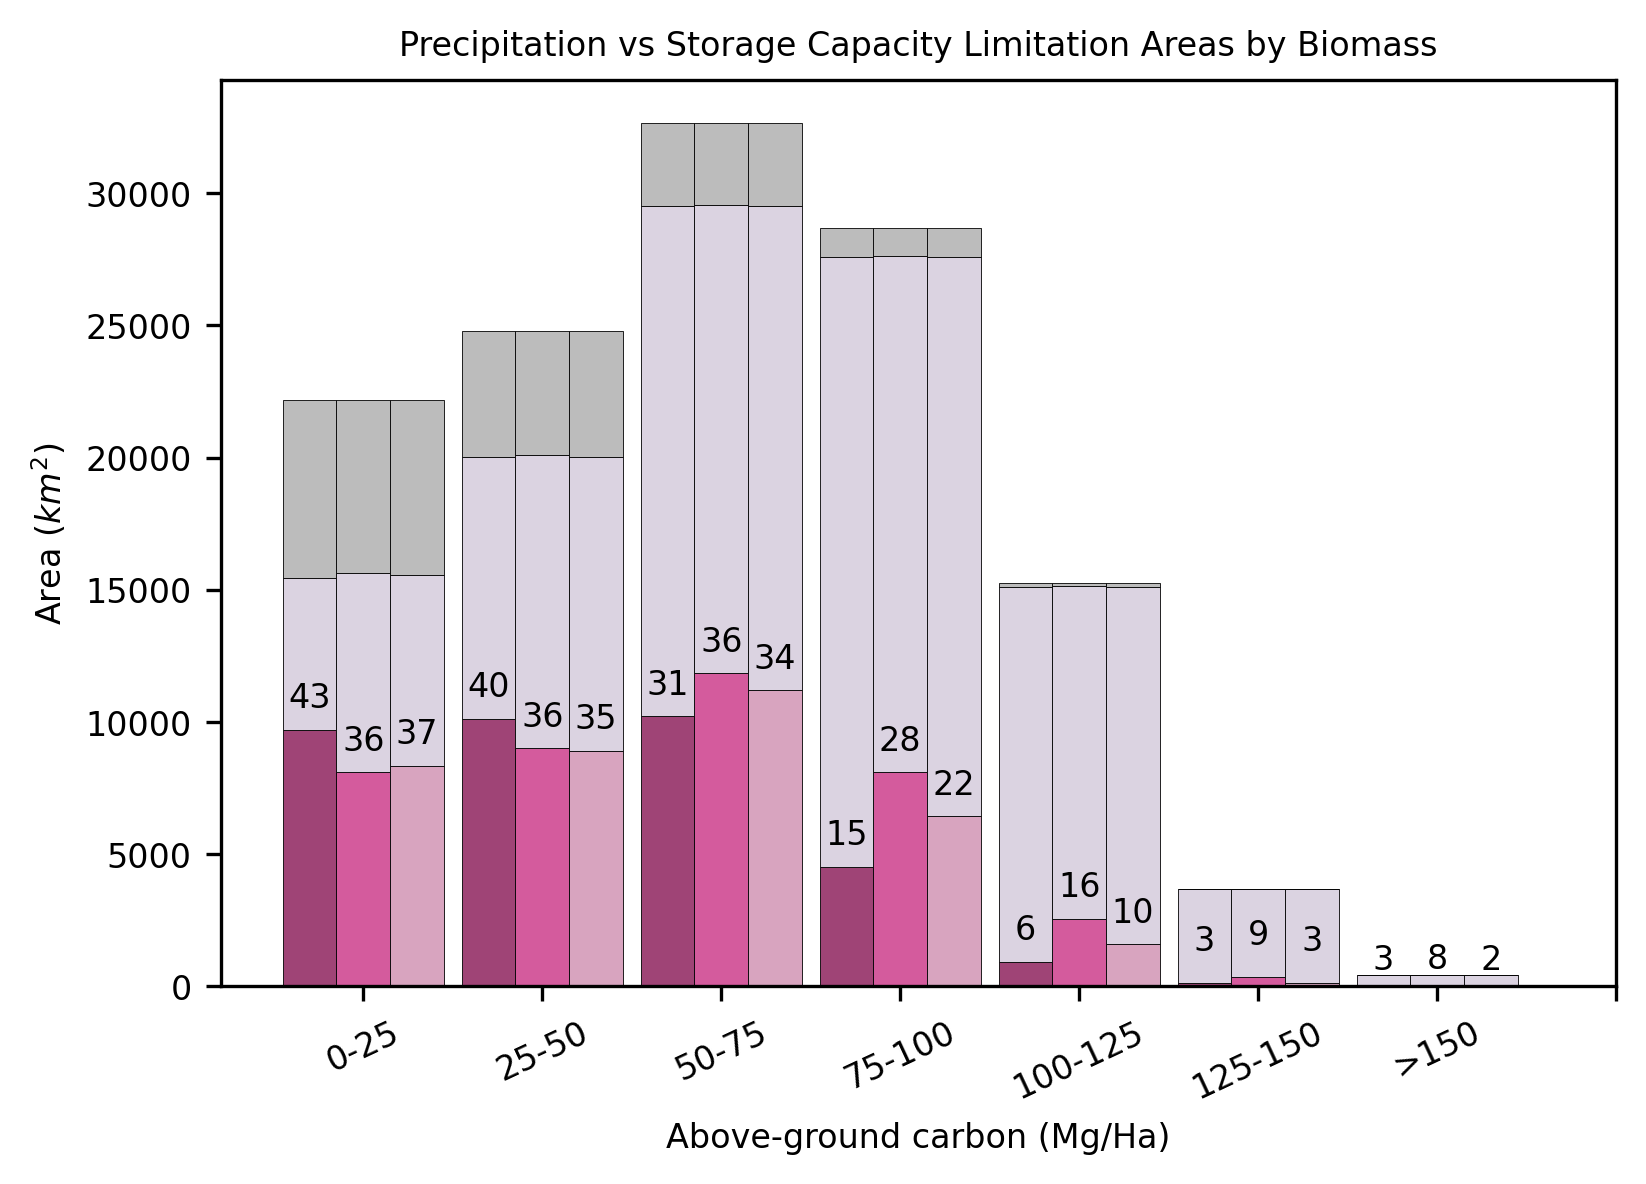

In [ ]:
make_boxplot('Biomass')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

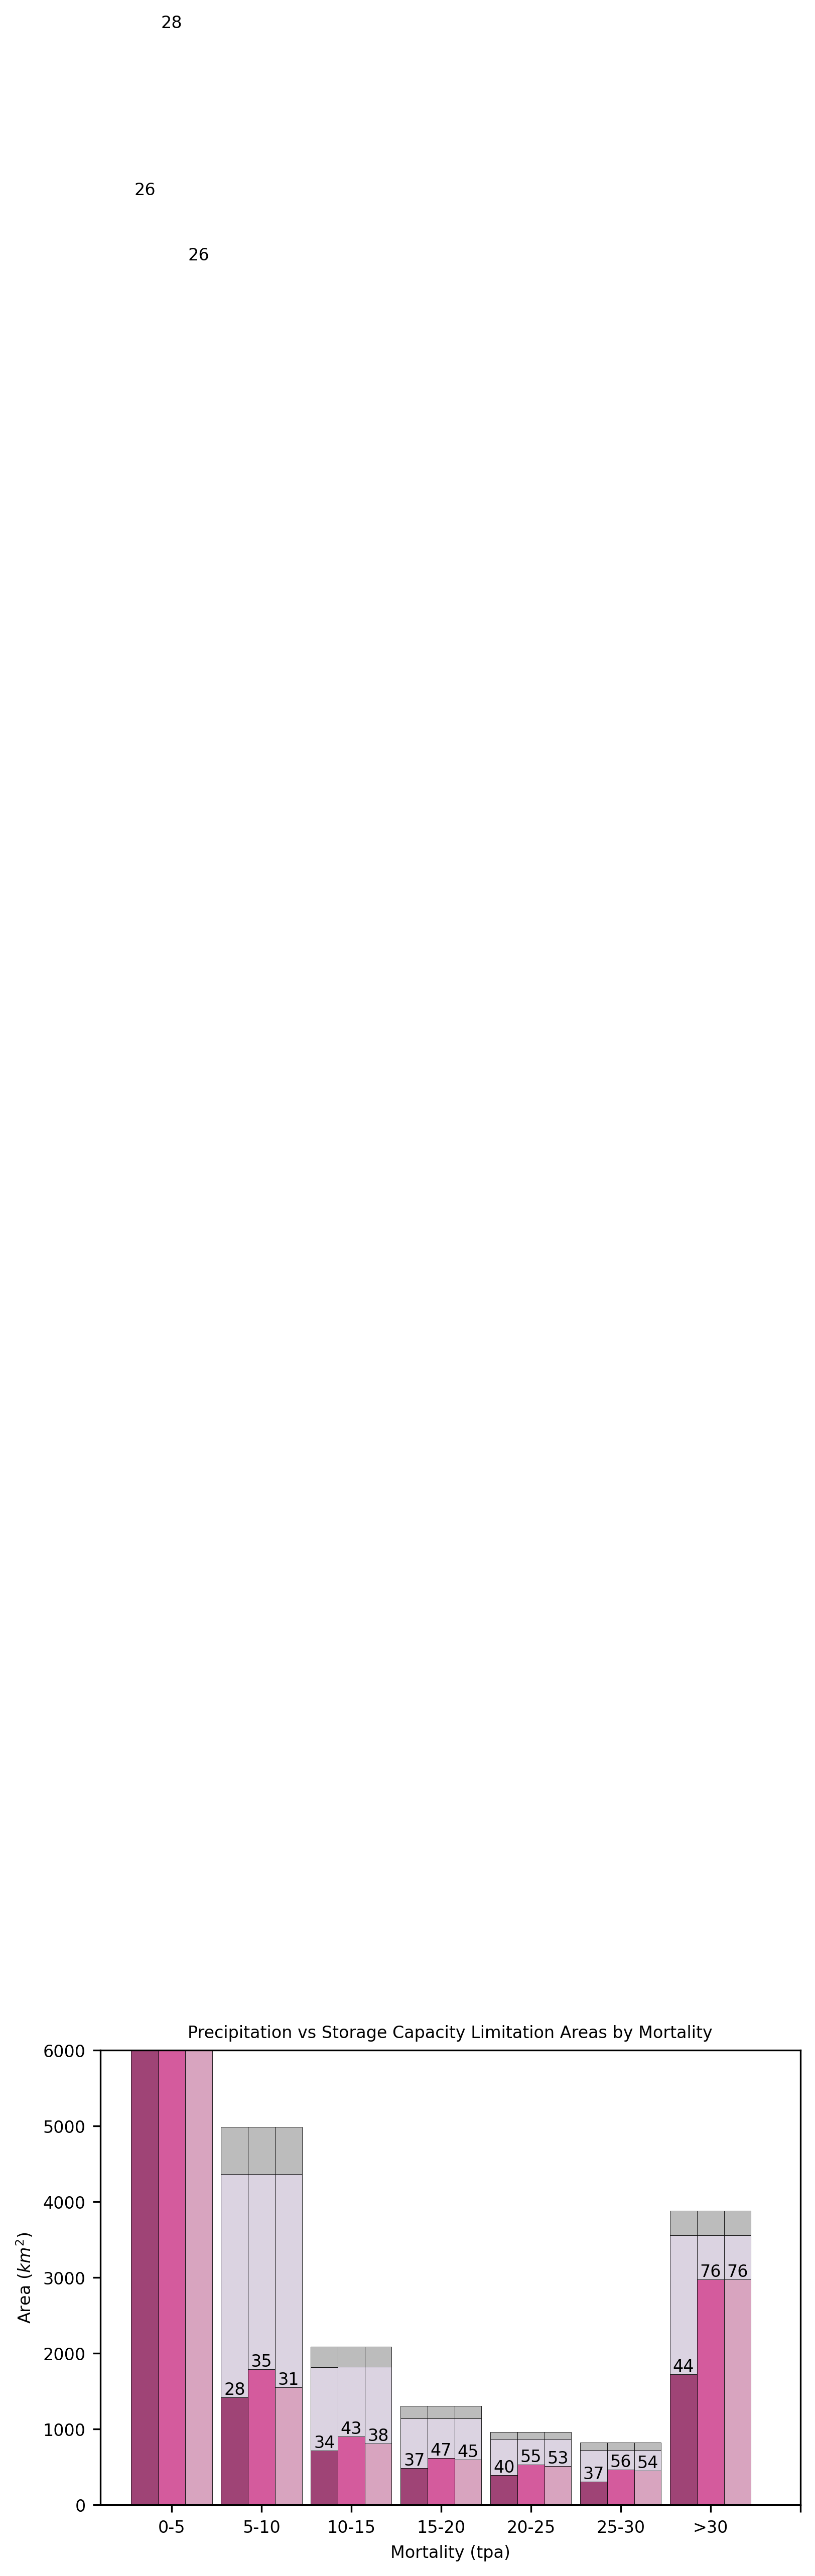

In [ ]:
make_boxplot('Mortality')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

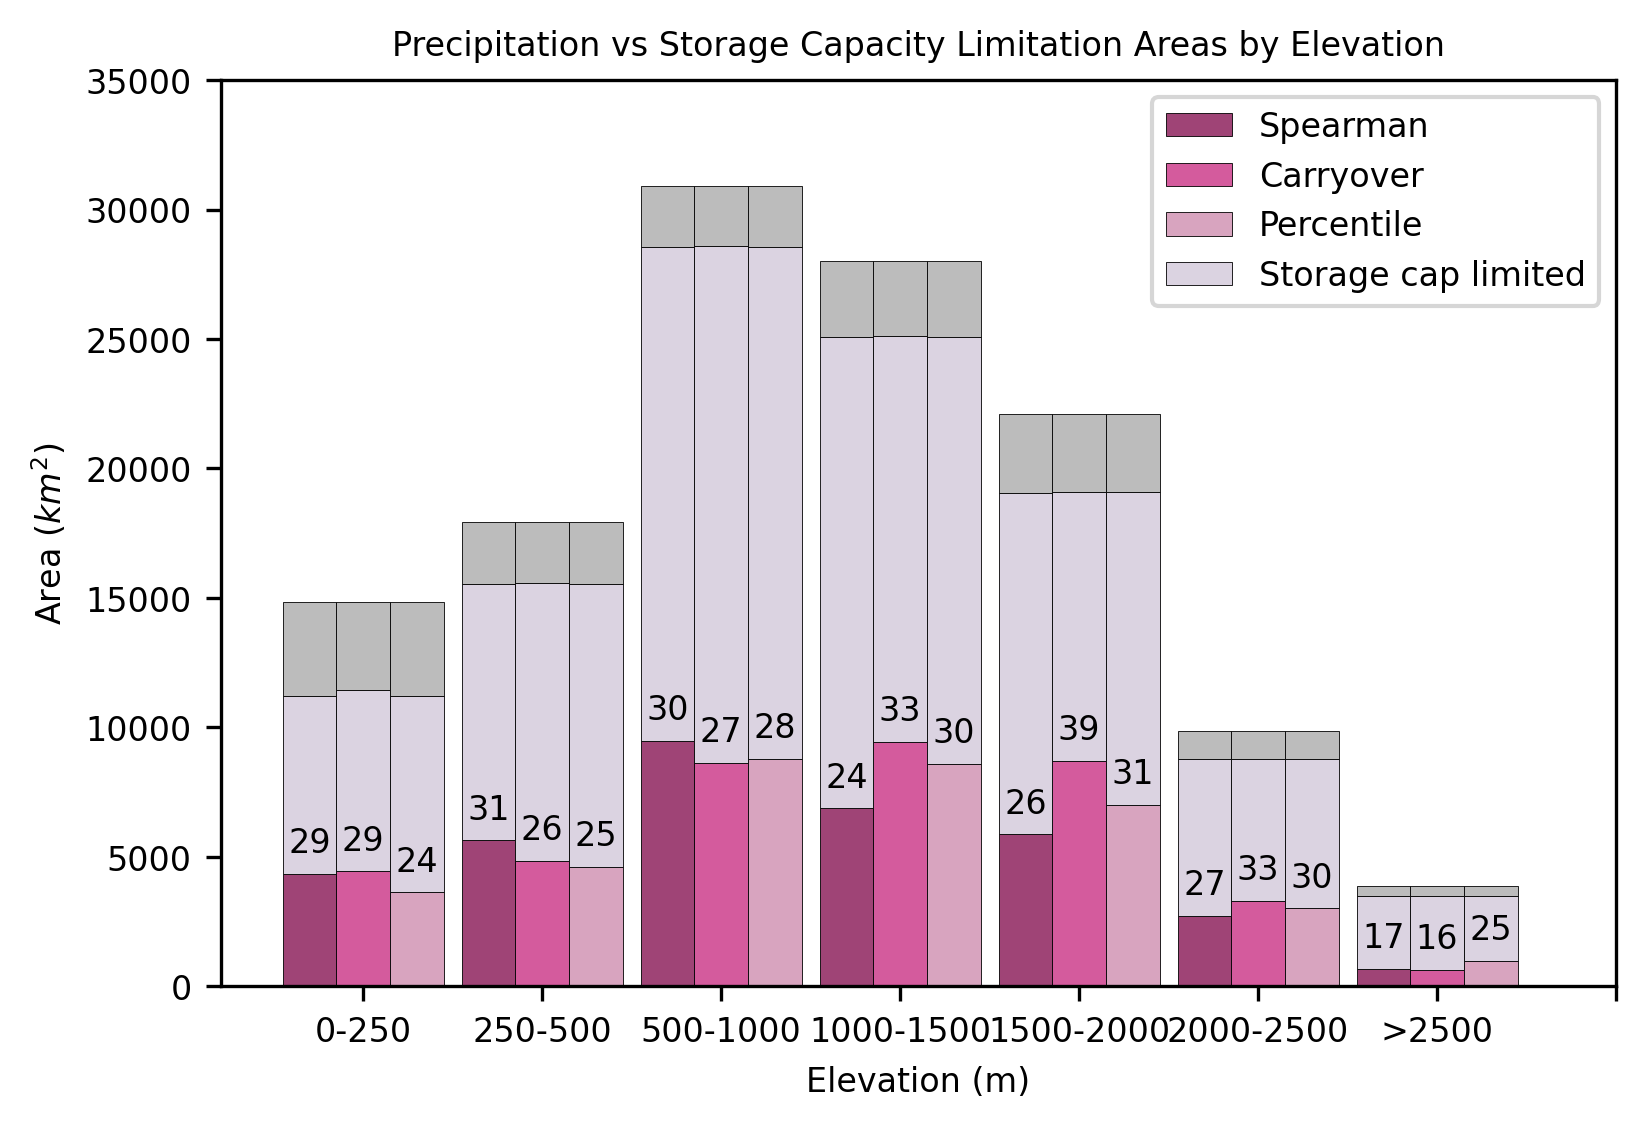

In [ ]:
make_boxplot('Elevation')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

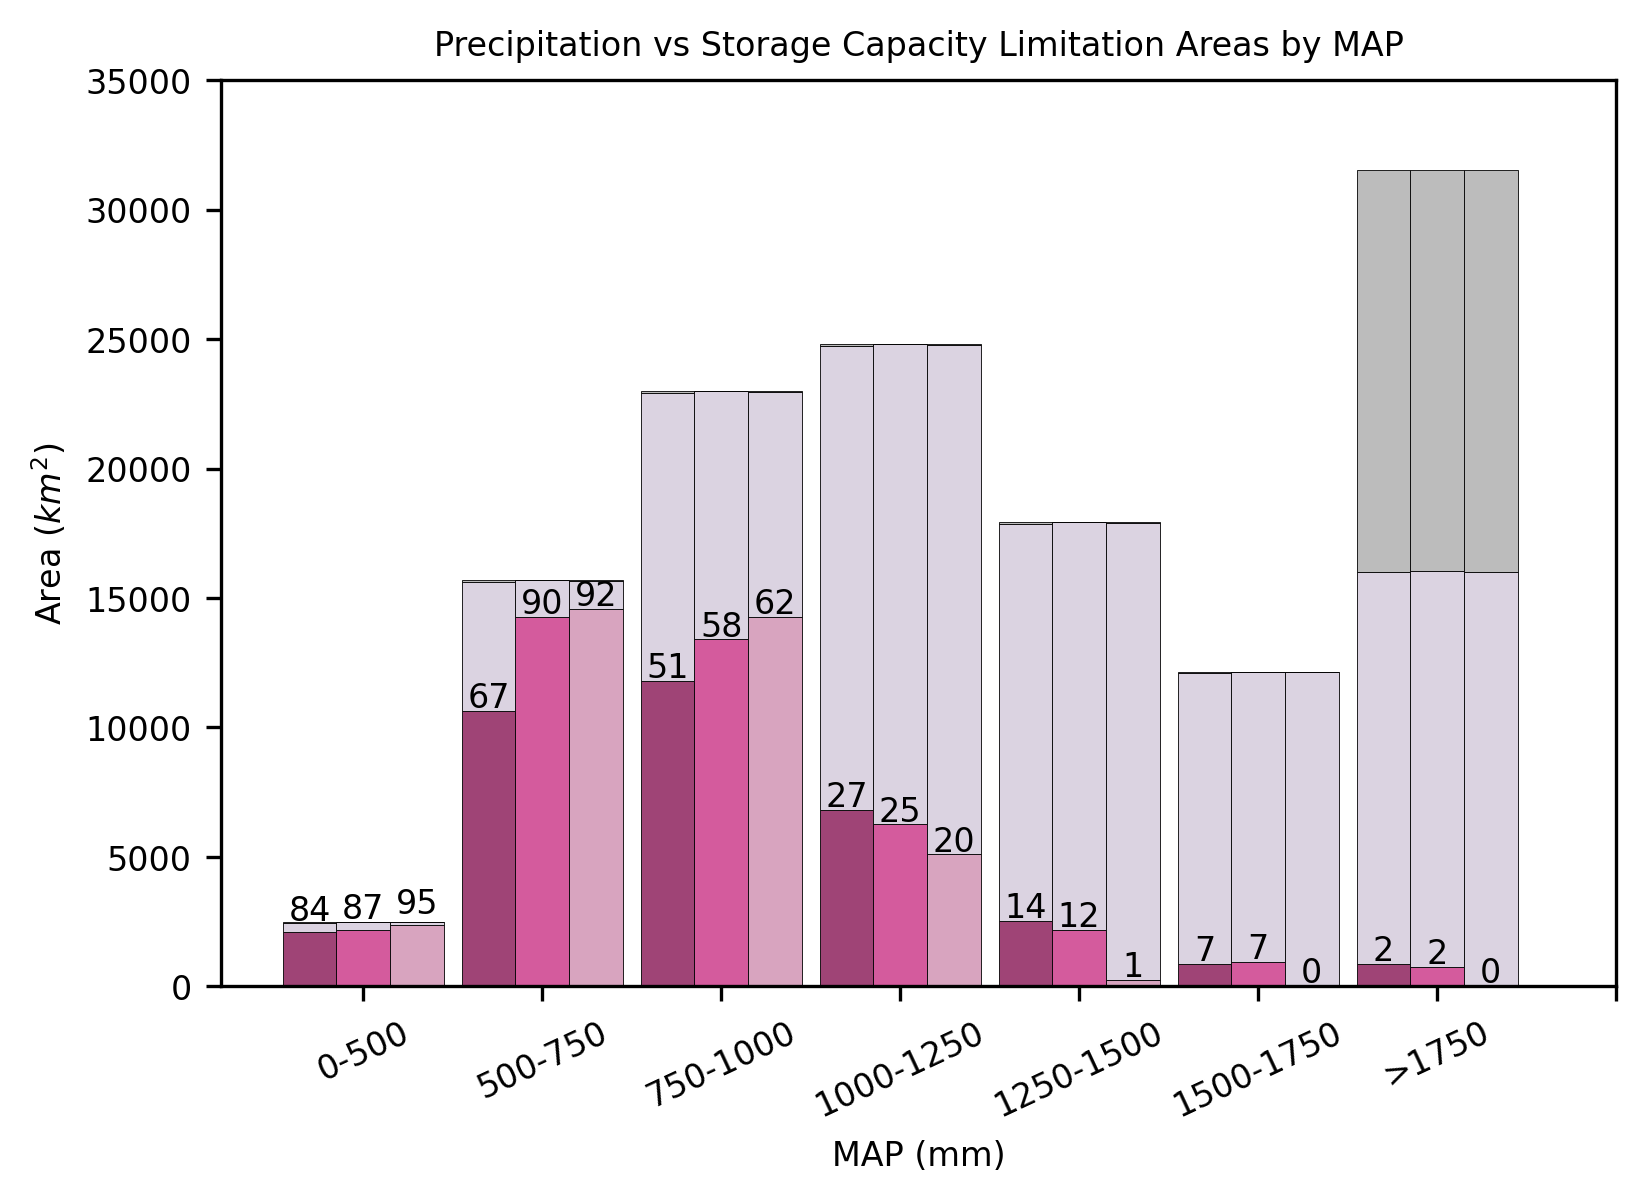

In [ ]:
make_boxplot('MAP')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

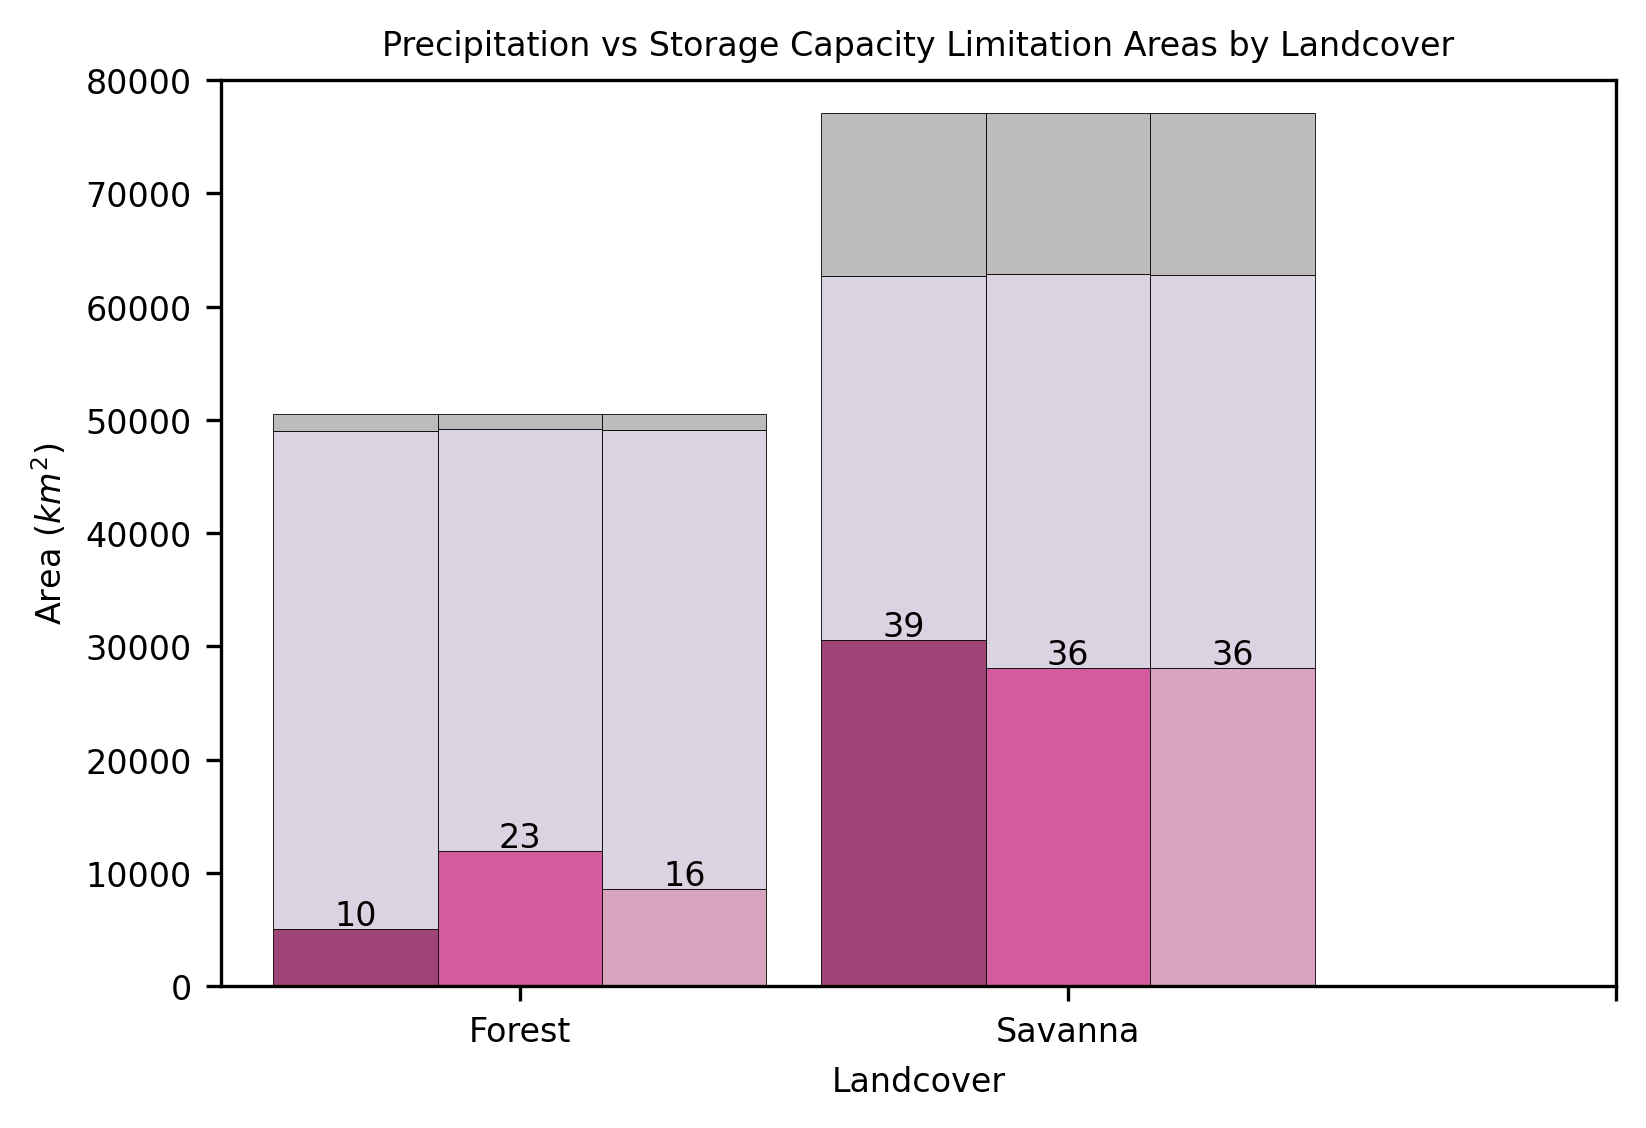

In [ ]:
make_boxplot('Landcover')

TypeError: ignored

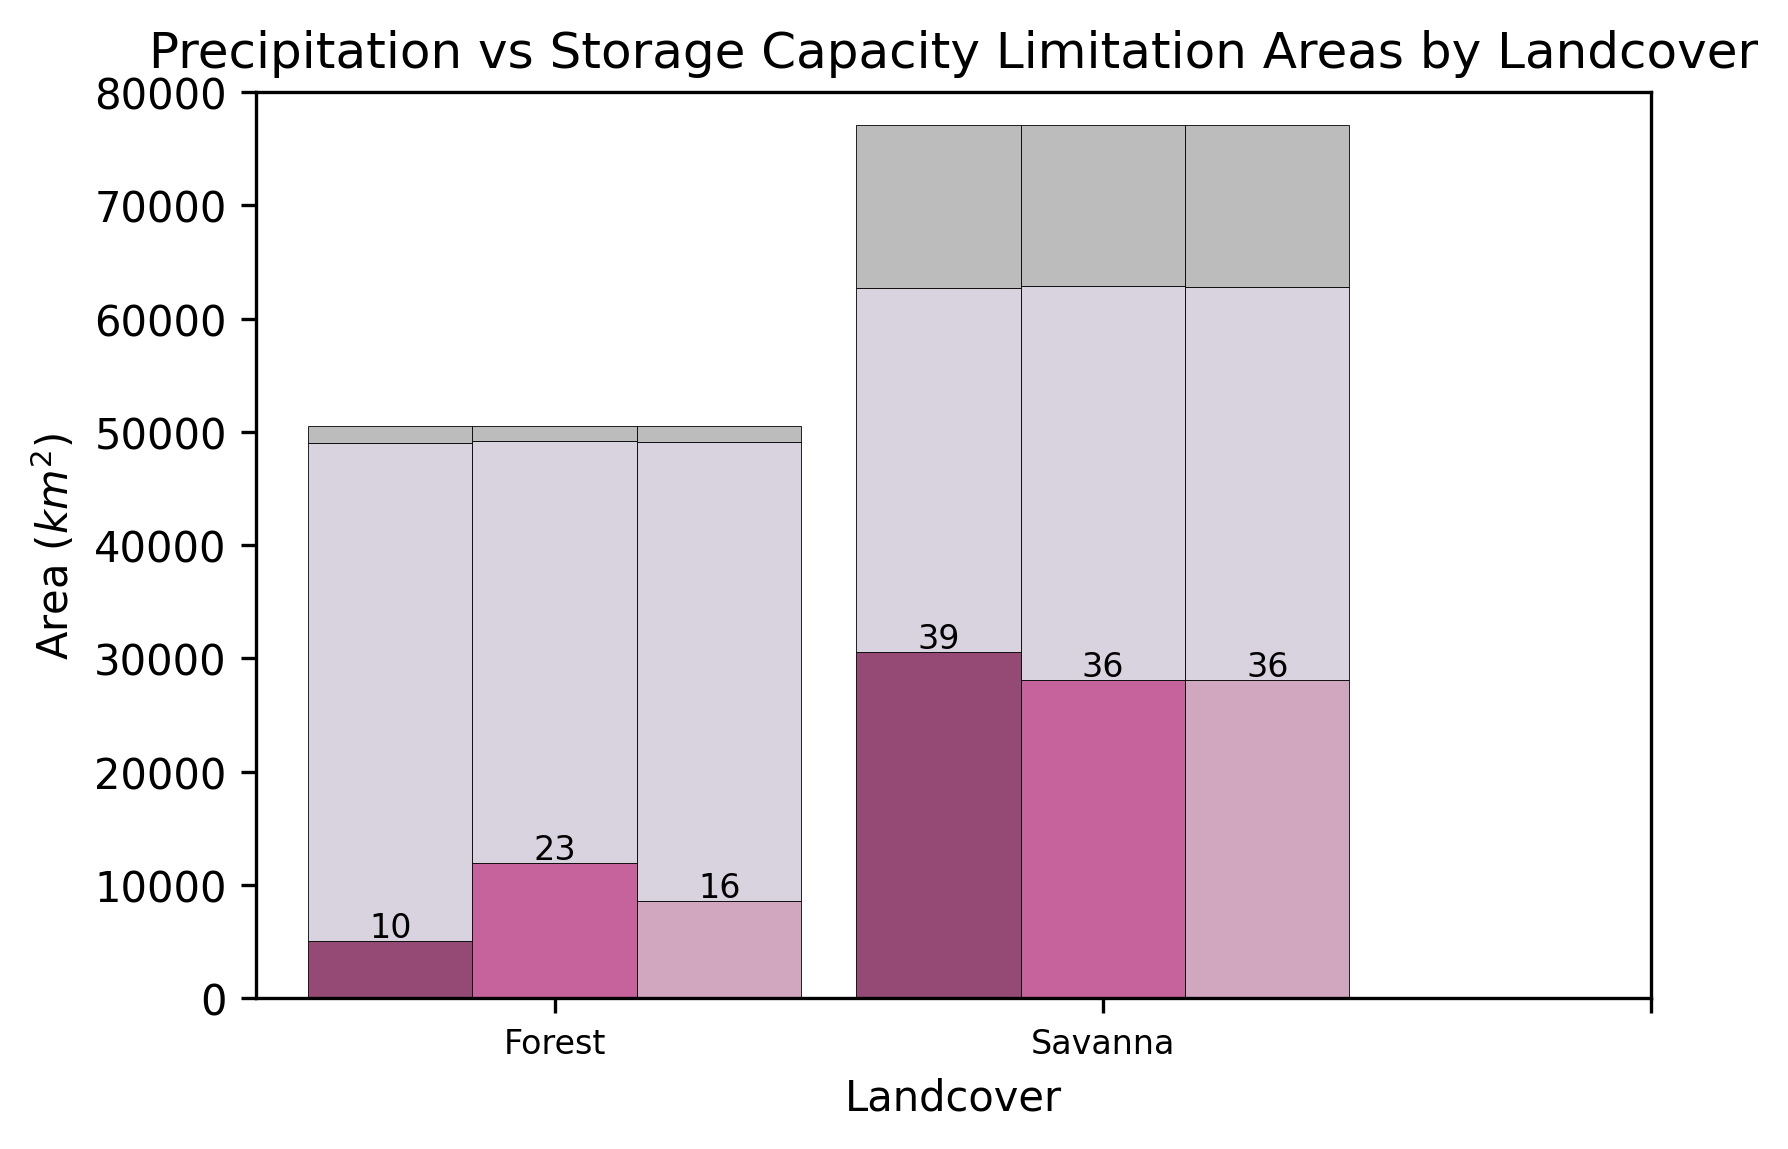

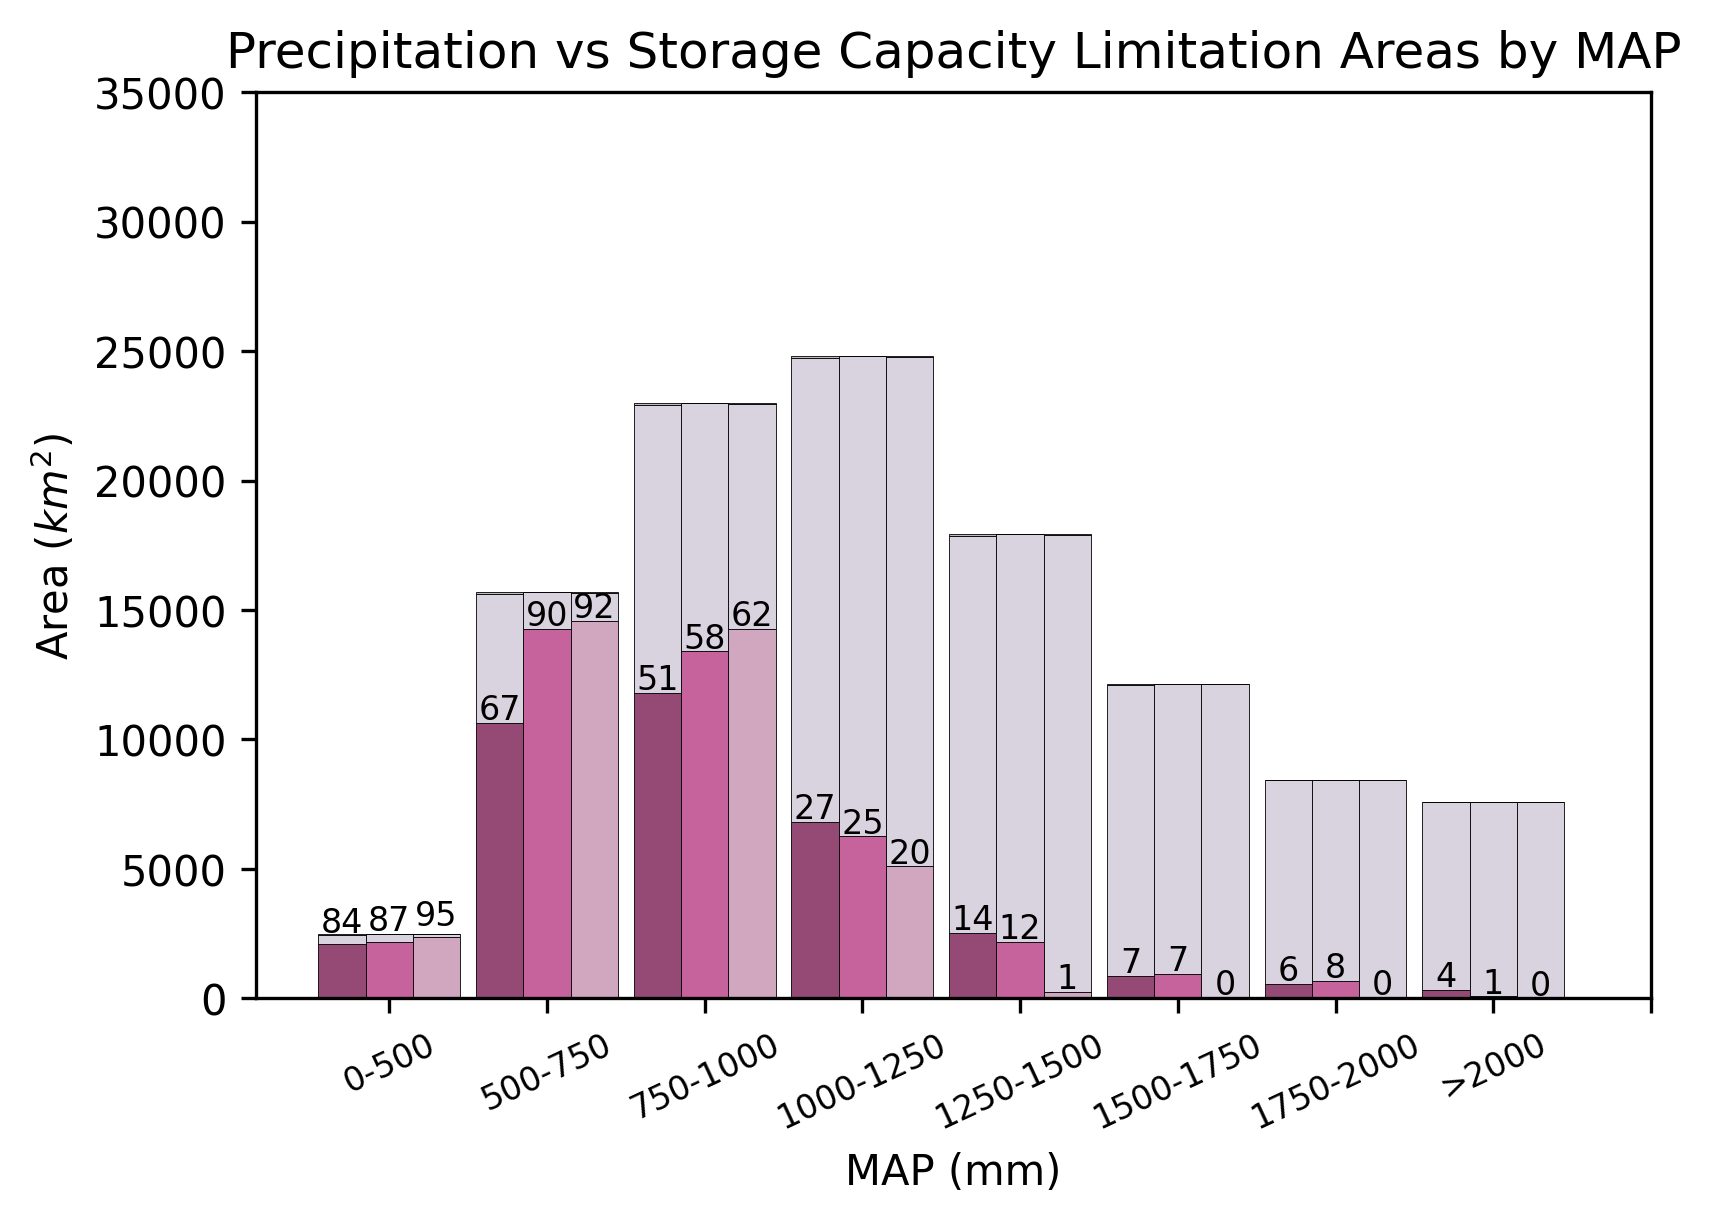

#**2.9** Statistics

The area and carbon statistics here use GEE assets of the products generated in sections 2.0 through 2.6.

In [42]:
def sum_area(input_image, band_name):
  reducer_result = input_image.reduceRegion(**{
    'reducer': ee.Reducer.sum(),
    'geometry': ca.geometry(), 
    'scale': 500,
    'maxPixels': 1e15
    })

  result = reducer_result.get(band_name).getInfo()
  return result

## Area

In [43]:
# Calculate woody veg area once
woodyveg_area = mask_landcover.gt(0).multiply(ee.Image.pixelArea())
total_area = woodyveg_area.reduceRegion(**{
  'reducer': ee.Reducer.sum(),
  'geometry': ca.geometry(), 
  'scale': 500,
  'maxPixels': 1e15
  })
total_woodyveg_area = total_area.get('remapped').getInfo()


def get_area_stats(woody_veg_area, mask):
    carryover_preciplim_area = carryover_perc.gt(0.09).multiply(ee.Image.pixelArea().reproject(crs='EPSG:4326',scale=500)).updateMask(mask)
    num = sum_area(carryover_preciplim_area, band_name = 'D')
    print('\nUsing carryover method:', round((num/woody_veg_area)*100),'%')
    spearman_preciplim_area = spearman_corr.gt(0.34).multiply(ee.Image.pixelArea().reproject(crs='EPSG:4326',scale=500)).updateMask(mask)
    num = sum_area(spearman_preciplim_area, band_name = 'b1')
    print('Using spearman method:', round((num/woody_veg_area)*100),'%')

    percentile_preciplim_area = percentile.gt(0).multiply(ee.Image.pixelArea().reproject(crs='EPSG:4326',scale=500)).updateMask(mask)
    num = sum_area(percentile_preciplim_area, band_name = 'b1')
    print('Using percentile method:', round((num/woody_veg_area)*100),'%')

def get_area_value(woody_veg_area, mask):
    carryover_preciplim_area = carryover_perc.gt(0.09).multiply(ee.Image.pixelArea().reproject(crs='EPSG:4326',scale=500)).updateMask(mask)
    carryover_num = sum_area(carryover_preciplim_area, band_name = 'D') * 1e-6
    print('\nUsing carryover method:', round(carryover_num), 'km^2')

    spearman_preciplim_area = spearman_corr.gt(0.34).multiply(ee.Image.pixelArea().reproject(crs='EPSG:4326',scale=500)).updateMask(mask)
    spearman_num = sum_area(spearman_preciplim_area, band_name = 'b1')* 1e-6
    print('Using spearman method:', round(spearman_num), 'km^2')

    percentile_preciplim_area = percentile.gt(0).multiply(ee.Image.pixelArea().reproject(crs='EPSG:4326',scale=500)).updateMask(mask)
    percentile_num = sum_area(percentile_preciplim_area, band_name = 'b1')* 1e-6
    print('Using percentile method:', round(percentile_num), 'km^2')


In [ ]:
print('Percent of woody vegetation in CA that is precipitation limited is:')
get_area_stats(woody_veg_area = total_woodyveg_area, mask = mask)

Percent of woody vegetation in CA that is precipitation limited is:

Using carryover method: 36 %
Using spearman method: 32 %
Using percentile method: 33 %


In [ ]:
# Percent of area where carryover > 0
def carryover_gt0_area(woody_veg_area):
  carryover_gt0 = carryover_perc.gt(0).multiply(ee.Image.pixelArea().reproject(crs='EPSG:4326',scale=500)) 
  num = sum_area(carryover_gt0, band_name = 'D')
  gt0 = round((num/woody_veg_area)*100)
  gt10 = 35.66 #from previous cell
  return gt0, gt10
gt0, gt10 = carryover_gt0_area(total_woodyveg_area)

print('Carryover storage was greater than zero for {} % of the woody vegetated area of California between 2003 and 2020 and exceeded 10% for {} % of the woody vegetated area.'.format(gt0, gt10))

Carryover storage was greater than zero for 89 % of the woody vegetated area of California between 2003 and 2020 and exceeded 10% for 35.66 % of the woody vegetated area.


In [ ]:
### Percent of forest and savanna areas separately ###

# Calculate forest area and savannah area once (returns in m^2)
def landcover_area(veg_type):
  if veg_type == 'Forest':
    area_raw = selected_landcover.lt(8).multiply(ee.Image.pixelArea().reproject(crs='EPSG:4326',scale=500))
  elif veg_type == 'Savannah':
    area_raw = selected_landcover.gt(7).multiply(ee.Image.pixelArea().reproject(crs='EPSG:4326',scale=500))
  else:
    print('Error: only Forest or Savannah veg_types are accepted.')

  area_summed = area_raw.reduceRegion(**{
    'reducer': ee.Reducer.sum(),
    'geometry': ca.geometry(), 
    'scale': 500,
    'maxPixels': 1e15
    })
  total_area = area_summed.get('b1').getInfo()
  return total_area

forest_area = landcover_area(veg_type = 'Forest')
savannah_area = landcover_area(veg_type = 'Savannah')


print('Percent of FORESTED vegetation in CA that is precipitation limited is:')
get_area_stats(woody_veg_area = forest_area, mask = selected_landcover.lt(8))

print('\nThis area is')
get_area_value(woody_veg_area = forest_area, mask = selected_landcover.lt(8))

print('\nPercent of SAVANNAH vegetation in CA that is precipitation limited is:')
get_area_stats(woody_veg_area = savannah_area, mask = selected_landcover.gt(7))

print('\nThis area is')
get_area_value(woody_veg_area = savannah_area, mask = selected_landcover.gt(7))


Percent of FORESTED vegetation in CA that is precipitation limited is:

Using carryover method: 24 %
Using spearman method: 10 %
Using percentile method: 17 %

This area is

Using carryover method: 11913 km^2
Using spearman method: 5056 km^2
Using percentile method: 8540 km^2

Percent of SAVANNAH vegetation in CA that is precipitation limited is:

Using carryover method: 36 %
Using spearman method: 40 %
Using percentile method: 36 %

This area is

Using carryover method: 28055 km^2
Using spearman method: 30557 km^2
Using percentile method: 28056 km^2


## Carbon

In [51]:
# Get total carbon in Mg first
ca_carbon = ee.Image('users/ericamccormick/20_RockMoisture/Other/aboveground_biomass_carbon_2010_scaled_CA') #Mg carbon /hectar
carbon_Mg = ca_carbon.multiply(ee.Image.pixelArea().reproject(crs='EPSG:4326',scale=500)).divide(10000) #Mg carbon
tot_ca_carbon = carbon_Mg.reduceRegion(**{
  'reducer': ee.Reducer.sum(),
  'geometry': ca.geometry(), 
  'scale': 500,
  'maxPixels': 1e15
  })
total_carbon = tot_ca_carbon.get('b1').getInfo()

# Function to get the amount of carbon for a given category
def get_carbon_stats(method, total_carbon = total_carbon, carbon_Mg = carbon_Mg, thresholds = thresholds):
    method_plim = thresholds[method]["asset_name"].gt(thresholds[method]["cutoff"])
    num = sum_area(carbon_Mg.updateMask(method_plim), band_name = "b1")
    print(method.upper())
    print(round((num/total_carbon)*100),'% of CA above-ground carbon stocks are in precipitation limited locations.')
    print('This amount of carbon is', round(num),'Mg, which is equal to',round(num/1e6),'Tg\n')



In [ ]:
get_carbon_stats(method = 'spearman')
get_carbon_stats(method = 'carryover')
get_carbon_stats(method = 'percentile')

SPEARMAN
16 % of CA above-ground carbon stocks are in precipitation limited locations.
This amount of carbon is 164053337 Mg, which is equal to 164 Tg

CARRYOVER
22 % of CA above-ground carbon stocks are in precipitation limited locations.
This amount of carbon is 221166307 Mg, which is equal to 221 Tg

PERCENTILE
19 % of CA above-ground carbon stocks are in precipitation limited locations.
This amount of carbon is 188096576 Mg, which is equal to 188 Tg



## Future

In [50]:
# DeltaP
danger_20 = deltaP_perc.gt(-0.2) # less than 20% change in 25th percentile of Pwy needed to transition
danger_10 = deltaP_perc.gt(-0.1) # less than 10% change in 25th percentile of Pwy needed to transition

danger20_area = sum_area(input_image = danger_20.multiply(ee.Image.pixelArea().reproject(crs='EPSG:4326',scale=500)), band_name = 'b1')* 1e-6
danger10_area = sum_area(input_image = danger_10.multiply(ee.Image.pixelArea().reproject(crs='EPSG:4326',scale=500)), band_name = 'b1')* 1e-6

print('The area where a 10 and 20% reduction in the 25th percentile of Pwy will result in transition from storage cap to precipitation limitation is:')
print('20%: ', round(danger20_area),'km^2','\n10%:', round(danger10_area), 'km^2')


# Model agreement

agr5 = future_agreement_transition.gte(5)
agr8 = future_agreement_transition.gte(8)

agr5_area = sum_area(input_image = agr5.multiply(ee.Image.pixelArea().reproject(crs='EPSG:4326',scale=500)), band_name = 'b1') * 1e-6
agr8_area = sum_area(input_image = agr8.multiply(ee.Image.pixelArea().reproject(crs='EPSG:4326',scale=500)), band_name = 'b1')* 1e-6

print('\nThe area where model agreement in future P indicates transition from storage cap to precipitation limitation is:')
print('5+ models agree: ', round(agr5_area),'km^2','\n8+ models agree:', round(agr8_area),'km^2')



The area where a 10 and 20% reduction in the 25th percentile of Pwy will result in transition from storage cap to precipitation limitation is:
20%:  1610 km^2 
10%: 661 km^2

The area where model agreement in future P indicates transition from storage cap to precipitation limitation is:
5+ models agree:  5354 km^2 
8+ models agree: 1385 km^2


In [48]:
# Model agreement

agr_worsening_gt0 = future_agreement_worsening.gt(0)
agr5_worsening = future_agreement_worsening.gte(5)
agr8_worsening = future_agreement_worsening.gte(8)

agr0_worsening_area = sum_area(input_image = agr_worsening_gt0.multiply(ee.Image.pixelArea().reproject(crs='EPSG:4326',scale=500)), band_name = 'b1_sum') * 1e-6
agr5_worsening_area = sum_area(input_image = agr5_worsening.multiply(ee.Image.pixelArea().reproject(crs='EPSG:4326',scale=500)), band_name = 'b1_sum') * 1e-6
agr8_worsening_area = sum_area(input_image = agr8_worsening.multiply(ee.Image.pixelArea().reproject(crs='EPSG:4326',scale=500)), band_name = 'b1_sum')* 1e-6

print('The area where model agreement (at least 1 model) says future P will cause worsening of plim:')
print(round(agr0_worsening_area), 'km^2')
print('\nThe area where model agreement in future P indicates worsening of precipitation limitation:')
print('5+ models agree: ', round(agr5_worsening_area),'km^2','\n8+ models agree:', round(agr8_worsening_area),'km^2')



The area where model agreement (at least 1 model) says future P will cause worsening of plim:
27656 km^2

The area where model agreement in future P indicates worsening of precipitation limitation:
5+ models agree:  12270 km^2 
8+ models agree: 5160 km^2


In [ ]:
# Compare to historical storage capacity limitation
# Total storage capacity limited area, according to historical percentile
perc_storagecap = percentile.eq(0).multiply(ee.Image.pixelArea().reproject(crs='EPSG:4326',scale=500)) 
perc_storagecap_area = sum_area(perc_storagecap, band_name = 'b1') * 1e-6
print('The percentile method for historical precipitation categorizes {} km^2 as storage capacity limited.'.format(round(perc_storagecap_area)))
print('For places where at least half of models agree on a transition, this leaves {} km^2 as storage capacity limited in the future.'.format(round(perc_storagecap_area -agr5_area)))

The percentile method for historical precipitation categorizes 75236 km^2 as storage capacity limited.
For places where at least half of models agree on a transition, this leaves 69882 km^2 as storage capacity limited in the future.


In [52]:
# Compared to the area of woody vegetation
total_woodyveg_km = total_woodyveg_area*1e-6
print('The area of transition relative to the total woody vegetated area is:')
print('10% reduction in P25 Pwy:',(danger10_area/total_woodyveg_km)*100,'%')
print('20% reduction in P25 Pwy:', (danger20_area/total_woodyveg_km)*100,'%')
print('5+ models agree:', (agr5_area/total_woodyveg_km)*100,'%')
print('8+ models agree:', (agr8_area/total_woodyveg_km)*100,'%')

print('5+ models agree on worsening precip lim:', (agr5_worsening_area/total_woodyveg_km)*100,'%')
print('8+ models agree on worsening precip lim:', (agr8_worsening_area/total_woodyveg_km)*100,'%')

The area of transition relative to the total woody vegetated area is:
10% reduction in P25 Pwy: 0.5896483192194831 %
20% reduction in P25 Pwy: 1.4361110713742447 %
5+ models agree: 4.776206799667912 %
8+ models agree: 1.2357153274203143 %
5+ models agree on worsening precip lim: 10.94658477621634 %
8+ models agree on worsening precip lim: 4.603441179033233 %


In [53]:
# How much carbon is this
def how_much_carbon(area_to_consider, total_carbon = total_carbon, carbon_Mg = carbon_Mg):
    num = sum_area(carbon_Mg.updateMask(area_to_consider), band_name = "b1")
    print(round((num/total_carbon)*100),'% of CA above-ground carbon stocks.')
    print('This amount of carbon is', round(num),'Mg, which is equal to',round(num/1e6),'Tg\n')

print('The amount of carbon in likely transition zones is:')
print('10% REDUCTION IN P25 Pwy:')
how_much_carbon(area_to_consider = danger_10)

print('20% REDUCTION IN P25 Pwy:')
how_much_carbon(area_to_consider = danger_20)

print('5+ MODELS AGREE:')
how_much_carbon(area_to_consider = agr5)

print('8+ MODELS AGREE:')
how_much_carbon(area_to_consider = agr8)

print('5+ MODELS AGREE ON WORSENING PRECIP LIM:')
how_much_carbon(area_to_consider = agr5_worsening)

print('8+ MODELS AGREE ON WORSENING PRECIP LIM:')
how_much_carbon(area_to_consider = agr8_worsening)

The amount of carbon in likely transition zones is:
10% REDUCTION IN P25 Pwy:
0 % of CA above-ground carbon stocks.
This amount of carbon is 1364494 Mg, which is equal to 1 Tg

20% REDUCTION IN P25 Pwy:
1 % of CA above-ground carbon stocks.
This amount of carbon is 6380590 Mg, which is equal to 6 Tg

5+ MODELS AGREE:
3 % of CA above-ground carbon stocks.
This amount of carbon is 28671600 Mg, which is equal to 29 Tg

8+ MODELS AGREE:
1 % of CA above-ground carbon stocks.
This amount of carbon is 6850856 Mg, which is equal to 7 Tg

5+ MODELS AGREE ON WORSENING PRECIP LIM:
6 % of CA above-ground carbon stocks.
This amount of carbon is 56639160 Mg, which is equal to 57 Tg

8+ MODELS AGREE ON WORSENING PRECIP LIM:
2 % of CA above-ground carbon stocks.
This amount of carbon is 23024821 Mg, which is equal to 23 Tg

